#Import

In [1]:
import sys
import os

py_file_location = "..."
sys.path.append(os.path.abspath(py_file_location))


In [2]:

from library import *
from model_DL import *
from functions import *
from metrics import *
from data_generator import *
from losses import *
from optimization import *
from parameters import *


/users/yacibena84/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/yacibena84/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/yacibena84/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/yacibena84/.local/lib/python3.6/site-packages/tensorflow/python/frame

In [7]:
!pip3 install sklearn --user

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/sh: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
    100% |################################| 20.0MB 71kB/s  eta 0:00:01
    100% |################################| 307kB 3.4MB/s eta 0:00:01
  Running setup.py bdist_wheel for sklearn ... done
  Stored in directory: /users/yacibena84/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [5]:
!pip3 install seaborn --user

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/sh: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
    100% |################################| 235kB 3.6MB/s eta 0:00:01


#Decode and forward

In [27]:
sigma

6

###Channel gain creation

In [21]:
ans=True
while ans:
    print("""
    1.Our model channel gain
    2.Uniform channel gain
    3.Exit/Quit
    """)
    ans=input("Select channel gain\n")
    if ans=="1":
      print("\n Channel gain created")
      # Acces Added
      GPP, GPR, GRP, GSS, GSR, GRS, GSP, GPS = gain_generator(Dpp_E), gain_generator(Dpr_E), gain_generator(Drp_E), gain_generator(Dss_E), gain_generator(Dsr_E), gain_generator(Drs_E), gain_generator(Dsp_E), gain_generator(Dps_E) # Acces Added
      ans = None
    elif ans=="2":
      print("\n Channel gain created")
      # Acces Added
      GPP, GPR, GRP, GSS, GSR, GRS, GSP, GPS  = uniform_gain()
      ans = None
    elif ans =='3':
      ans = None
    else:
       print("\n Not Valid Choice Try again")


    1.Our model channel gain
    2.Uniform channel gain
    3.Exit/Quit
    
Select channel gain
1

 Channel gain created


In [28]:
GPR.shape

(200000,)

###Dataset creation

In [24]:
results = mult_res(BF_A, GRP[:Nbr], GPP[:Nbr], GSR[:Nbr], GPR[:Nbr], GSS[:Nbr], GRS[:Nbr], GSP[:Nbr], GPS[:Nbr])

outfile = 'Data/dataset/dataset_test_dim10_sigma_7'
#DS = dataset_A(GRP, GPP, GSR, GPR, GSS, GRS, GSP, results[:,7], results[:,8], results[:,9], results[:,10])

DS = dataset(GRP[:Nbr], GPP[:Nbr], GSR[:Nbr], GPR[:Nbr], GSS[:Nbr], GRS[:Nbr], GSP[:Nbr], GPS[:Nbr], results[:,8], results[:,9], results[:,10], results[:,11])

np.savez(outfile, DS)
print("\n dataset generation finished")




 dataset generation finished


In [5]:
def dataset_train(Grp, Gpp, Gsr, Gpr, Gss, Grs, Gsp, Gps):
  """Different channel gain, alpha, powers and debit for the bruteforce method"""

  return np.stack((Grp, Gpp, Gsr, Gpr, Gss, Grs, Gsp, Gps), axis=1)

# refaire une dataset avec train sigma = 7 

outfile = 'Data/dataset/dataset_train_dim10_sigma_7'

DS = dataset_train(GRP, GPP, GSR, GPR, GSS, GRS, GSP, GPS)
np.savez(outfile, DS)
print("\n dataset generation finished")





 dataset generation finished


$Split\ dataset$

In [9]:
# if dataset already created (load it)
### Train ### ==> ('dataset_BF_train')
dataset_train = np.load('Data/dataset/dataset_train_dim10.npz')
dataset_train.files
dataset_train = dataset_train['arr_0']

### Test ### ==> np.load('dataset_BF_test_A')
dataset_test = np.load('Data/dataset/dataset_test_dim10.npz')
dataset_test.files
dataset_test = dataset_test['arr_0']

In [10]:
x_train = dataset_train[:,0:8]
x_test, y_test = dataset_test[:,0:8], dataset_test[:,8:12]

###Unsupervised Learning

##Principal model

####Parameters

In [11]:
Epochs = 200 # Epochs number


BS = 4096 # batch_size

VS = 0.2 # validation_split

metrics = [Achievable_Rate(tau), QoS_Violation(tau), Primary_Achievable_Rate_Degradation, Primary_ARD_Percentage(tau)] #, QoS_mean_DF, QoS_median_DF

####Model

####Multiple fit

In [12]:
def loss_DF_WN(Lambda, v_tau):
  def DF_loss(G, y_out):
    ''' compute loss without normalization'''
    Tau = tf.constant(v_tau, dtype=tf.float32) # ==> Tau 
    W = tf.constant(Lambda, dtype=tf.float32)  # ==> lambda 
    
    G = tf.cast(G, dtype='float32')
    y_out = tf.cast(y_out, dtype='float32')
    
    # index retrieval

    Grp_indx, Gpp_indx, Gsr_indx, Gpr_indx, Gss_indx, Grs_indx, Gsp_indx, Gps_indx  = [0], [1], [2], [3], [4], [5], [6], [7]
    Alpha_indx, Pr_indx, Ps_indx  = [0], [1], [2]

    # tensors retrieval
    Grp, Gpp, Gsr, Gpr, Gss, Grs, Gsp, Gps, Alpha, Pr, Ps = tf.gather(G, Grp_indx, axis=1), tf.gather(G, Gpp_indx, axis=1), tf.gather(G, Gsr_indx, axis=1), tf.gather(G, Gpr_indx, axis=1), tf.gather(G, Gss_indx, axis=1), tf.gather(G, Grs_indx, axis=1), tf.gather(G, Gsp_indx, axis=1), tf.gather(G, Gps_indx, axis=1), tf.gather(y_out, Alpha_indx, axis=1), tf.gather(y_out, Pr_indx, axis=1), tf.gather(y_out, Ps_indx, axis=1)

    #  Primary power Creation
    
    Pp = tf.multiply(tf.ones(tf.shape(Pr), dtype=tf.dtypes.float32),10)
    
    # SNR1 : (Gsr*(1-alpha**2)*Ps**2)/(Gpr*Pp+1)
    SNR1 = tf.multiply(Gsr,(tf.multiply(tf.subtract(tf.constant(1,dtype=tf.float32), tf.pow(Alpha, 2)), tf.pow(Ps, 2))))
    SNR1 = tf.divide(SNR1, tf.add(tf.multiply(Gpr, Pp), tf.constant(1,dtype=tf.float32)))

    # SNR2 : ((Gss*Ps**2+Grs*Pr**2)+2*(np.sqrt(Grs*Gss)*Alpha*Ps*Pr)) ==> L1+L2/Gps*Pp+1
    L1 = tf.add(tf.multiply(Gss,tf.pow(Ps,2)),tf.multiply(Grs,tf.pow(Pr,2)))
    L2 = tf.multiply(tf.constant(2,dtype=tf.float32),tf.multiply(tf.multiply(tf.sqrt(tf.multiply(Grs,Gss)),Ps),tf.multiply(Alpha,Pr)))
    
    SNR2 = tf.add(L1,L2)
    SNR2= tf.divide(SNR2, tf.add(tf.multiply(Gps, Pp),tf.constant(1,dtype=tf.float32)))
    
    SNR_opt = tf.minimum(SNR1, SNR2)

    ########### QoS ################
    
    # function A' ==> A'(Gpp) : ((Gpp*Pp)/((1+(Gpp*Pp))**(1-tau)-1))-1 ==> (Gpp*Pp)/(R1) 
    R1 = tf.add(tf.constant(1, dtype=tf.float32),tf.multiply(Gpp,Pp))
    R1 = tf.pow(R1, tf.math.subtract(tf.constant(1, dtype=tf.float32),Tau))
    R1 = tf.math.subtract(R1,tf.constant(1, dtype=tf.float32))

    A_ = tf.subtract(tf.divide(tf.multiply(Gpp,Pp),R1),tf.constant(1, dtype=tf.float32))
  

    #Qos = (Gsp*Ps**2+Grp*Pr**2+2*np.sqrt(Gsp*Grp)*Alpha*Ps*Pr)-A_
    Qos = tf.add(tf.add(tf.multiply(Gsp,tf.pow(Ps,2)),tf.multiply(Grp,tf.pow(Pr,2))),tf.multiply(tf.constant(2,dtype=tf.float32),tf.multiply(tf.sqrt(tf.multiply(Gsp,Grp)),tf.multiply(Ps,tf.multiply(Alpha,Pr)))))
    
    Qos = tf.subtract(Qos, A_)

    n_Qos = tf.multiply(W,tf.keras.activations.relu(Qos)) 
    
    Rs_opt =  tf.multiply(tf.constant(0.5, dtype=tf.float32),tf.experimental.numpy.log2(tf.add(tf.constant(1,dtype=tf.float32),SNR_opt)))

    #-n_SNR+n_Qos
    res = tf.reduce_mean(-Rs_opt+n_Qos) 

    return res
  return DF_loss

In [18]:

LD = {'10_-1':10**-1,'10_-0.75':10**-0.75,'10_-0.5':10**-0.5,'10_-0.25':10**-0.25,'10_0':10**0,'10_0.25':10**0.25,'10_0.5':10**0.5,'10_0.75':10**0.75,'10_1':10**1,'10_1.25':10**1.25,'10_1.5':10**1.5,'10_1.75':10**1.75,'10_2':10**2}


#,'10_2.5':10**2.5,'10_3':10**3
LR = {'10_-4':10**-4}
#

for ld_k, ld_v in LD.items():
 
  #Create a new directory (a folder) in Drive
  tf.io.gfile.makedirs('model_train_WN_VF_dim10/Lambda = '+ld_k)
  tf.io.gfile.makedirs('model_train_WN_VF_dim10/Lambda = '+ld_k+'/weights/')
  tf.io.gfile.makedirs('model_train_WN_VF_dim10/Lambda = '+ld_k+'/history/')

  for lr_k, lr_v in LR.items():
    model = model_DL.get_model_DF(x_train, loss_DF_WN(ld_v,tau), metrics,'sigmoid', custom_sigmoid, custom_sigmoid, lr_v)
    history = model.fit(x_train, x_train, epochs=200, batch_size=4096, validation_split = VS)

    model.save('model_train_WN_VF_dim10/Lambda = '+ld_k+'/weights/'+lr_k+'.h5')
    np.save('model_train_WN_VF_dim10/Lambda = '+ld_k+'/history/'+lr_k+'.npy',history.history)





NameError: name 'model_DL' is not defined

### Pretrained Model

####Load model (weights and training history)

In [106]:
def ARD_mean(Grp, Gpp, Gsp, Alpha, Pr, Ps):
  """
    Mean of Primary achievable rate degradation.

    Parameters:
      Grp: 1D Array containing Channel Gain between relay and primary receiver.
      Gpp: 1D Array containing Channel Gain between primary transmitter and primary receiver.
      Gsp: 1D Array containing Channel Gain between secondary transmitter and primary receiver.
      Alpha: 1D Array containing Alpha values.
      Pr: 1D Array containing Power of relay.
      Ps: 1D Array containing Power of secondary network.

    Returns:
      Mean for Primary achievable rate degradation
  """
  res = pdd(Grp, Gpp, Gsp, Alpha, Pr, Ps)
  res = res[res>tau]
  with warnings.catch_warnings():
    warnings.filterwarnings('error')
    try:
        mean = np.nanmean(res)
    except RuntimeWarning:
        mean = 0
  return mean

def ARD_median(Grp, Gpp, Gsp, Alpha, Pr, Ps):
  """
    median of Primary achievable rate degradation.

    Parameters:
      Grp: 1D Array containing Channel Gain between relay and primary receiver.
      Gpp: 1D Array containing Channel Gain between primary transmitter and primary receiver.
      Gsp: 1D Array containing Channel Gain between secondary transmitter and primary receiver.
      Alpha: 1D Array containing Alpha values.
      Pr: 1D Array containing Power of relay.
      Ps: 1D Array containing Power of secondary network.

    Returns:
      median for Primary achievable rate degradation
  """
  res = pdd(Grp, Gpp, Gsp, Alpha, Pr, Ps)
  res = res[res>tau]
  with warnings.catch_warnings():
    warnings.filterwarnings('error')
    try:
        median = np.nanmean(res)
    except RuntimeWarning:
        median = 0 
  return median


In [112]:
# modified part

LD = {'10_-1':10**-1,'10_-0.75':10**-0.75,'10_-0.5':10**-0.5,'10_-0.25':10**-0.25,'10_0':10**0,'10_0.25':10**0.25,'10_0.5':10**0.5,'10_0.75':10**0.75,'10_1':10**1,'10_1.25':10**1.25,'10_1.5':10**1.5,'10_1.75':10**1.75,'10_2':10**2}

LR = {'10_-4':10**-4}


predicted_debit = []
predicted_debit_all = []
debit_gap, debit_gap_all = np.array([]), []

debit_rmse, debit_rmse_all = np.array([]), []
debit_nrmse, debit_nrmse_all = np.array([]), []
debit_r2, debit_r2_all = np.array([]), []

pdd_vmin, pdd_vmax, pdd_vmean, pdd_vstd = np.array([]), np.array([]), np.array([]), np.array([])
pdd_vmin_all, pdd_vmax_all, pdd_vmean_all, pdd_vstd_all = [], [], [], []

viloated_tau, viloated_tau_all = np.array([]), []
ard_mean, ard_mean_all = np.array([]), []
ard_median, ard_median_all = np.array([]), []

for ld_k in LD.keys():

  for lr_k in LR.keys():

      model = tf.keras.models.load_model('/model_train/Lambda = '+ld_k+'/weights/'+lr_k+'.h5', custom_objects={'DF_loss':loss_DF(Lambda,tau),'Primary_Achievable_Rate_Degradation':Primary_Achievable_Rate_Degradation,'Primary_ARDP':Primary_ARD_Percentage,'throughput':Achievable_Rate(tau),'V_Qos':QoS_Violation(tau), "custom_sigmoid":custom_sigmoid})

      ##### Evaluation on test set #####
      predictions = model.predict(x_test)
    
      # debit calculation for ground truth and predicted test set
      debit_hat_test = debit(x_test[:,0], x_test[:,1], x_test[:,2], x_test[:,3],x_test[:,4], x_test[:,5], x_test[:,6], x_test[:,7], predictions[:,0], predictions[:,1], predictions[:,2])
      debit_true_test = dataset(x_test[:,0], x_test[:,1], x_test[:,2], x_test[:,3],x_test[:,4], x_test[:,5], x_test[:,6], x_test[:,7], y_test[:,0], np.sqrt(y_test[:,1]), np.sqrt(y_test[:,2]), np.sqrt(y_test[:,3]))

      
      #predicted debit
  
      predicted_debit.append(debit_hat_test[:,8]) 
     
      ###### Gap Acheivable rate ######
      #Avreage debit gap between predicted and Brutefroce debit
      debit_gap = np.append(debit_gap, avreage_gap(debit_hat_test[:,8], debit_true_test[:,8])) #[:,7] : extracting debit from ND array
      # root_mean_squared_error 
      debit_rmse = np.append(debit_rmse,mean_squared_error(debit_hat_test[:,8], debit_true_test[:,8], squared=True))
      # normalized root_mean_squared_error 
      debit_nrmse = np.append(debit_nrmse, nrmse(debit_hat_test[:,8], debit_true_test[:,8]))
      # R2_square 
      debit_r2 = np.append(debit_r2,r2_score(debit_hat_test[:,8], debit_true_test[:,8]))
      
      ###### Primary degradation Violation ######
      #  Primary degradation percentage, mean and median calculation
      # qos_violation calculation
      tau_violation_count = Tau_Violation_Number(x_test[:,0], x_test[:,1], x_test[:,6], predictions[:,0], predictions[:,1], predictions[:,2]) 

      viloated_tau = np.append(viloated_tau, Tau_Violation_percentage(x_test, tau_violation_count))

      ard_mean = np.append(ard_mean, ARD_mean(x_test[:,0], x_test[:,1], x_test[:,6], predictions[:,0], predictions[:,1], predictions[:,2]))
      ard_median = np.append(ard_median, ARD_median(x_test[:,0], x_test[:,1], x_test[:,6], predictions[:,0], predictions[:,1], predictions[:,2]))

      # min, max, mean and std for primary debit degradation
      pdd_vmin, pdd_vmax, pdd_vmean, pdd_vstd =  np.append(pdd_vmin,pdd_min(x_test[:,0], x_test[:,1], x_test[:,6], predictions[:,0], predictions[:,1], predictions[:,2])), np.append(pdd_vmax,pdd_max(x_test[:,0], x_test[:,1], x_test[:,6], predictions[:,0], predictions[:,1], predictions[:,2])), np.append(pdd_vmean, pdd_mean(x_test[:,0], x_test[:,1], x_test[:,6], predictions[:,0], predictions[:,1], predictions[:,2])), np.append(pdd_vstd,pdd_std(x_test[:,0], x_test[:,1], x_test[:,6], predictions[:,0], predictions[:,1], predictions[:,2]))  
  # append data from the temporary list to the principal list
  debit_gap_all.append(debit_gap)
  debit_rmse_all.append(debit_rmse)
  debit_nrmse_all.append(debit_nrmse)
  debit_r2_all.append(debit_r2)

  predicted_debit_all.append(predicted_debit)

  viloated_tau_all.append(viloated_tau)
  ard_mean_all.append(ard_mean)
  ard_median_all.append(ard_median)

  pdd_vmin_all.append(pdd_vmin)
  pdd_vmax_all.append(pdd_vmax)
  pdd_vmean_all.append(pdd_vmean)
  pdd_vstd_all.append(pdd_vstd)

  # empty temporary lists
  predicted_debit = []
  debit_gap, viloated_tau = np.array([]), np.array([])
  debit_rmse, debit_nrmse, debit_r2  = np.array([]), np.array([]), np.array([])

  pdd_vmin, pdd_vmax, pdd_vmean, pdd_vstd = np.array([]), np.array([]), np.array([]), np.array([])
  ard_mean, ard_median = np.array([]), np.array([])

/content/drive/MyDrive/Colab Notebooks/CodeVF/metrics.py:231: RuntimeWarning: divide by zero encountered in double_scalars
  return mean_squared_error(actual, predicted, squared=True) / (actual.max() - actual.min())
/content/drive/MyDrive/Colab Notebooks/CodeVF/metrics.py:231: RuntimeWarning: divide by zero encountered in double_scalars
  return mean_squared_error(actual, predicted, squared=True) / (actual.max() - actual.min())
/content/drive/MyDrive/Colab Notebooks/CodeVF/metrics.py:231: RuntimeWarning: divide by zero encountered in double_scalars
  return mean_squared_error(actual, predicted, squared=True) / (actual.max() - actual.min())
/content/drive/MyDrive/Colab Notebooks/CodeVF/metrics.py:231: RuntimeWarning: divide by zero encountered in double_scalars
  return mean_squared_error(actual, predicted, squared=True) / (actual.max() - actual.min())
/content/drive/MyDrive/Colab Notebooks/CodeVF/metrics.py:231: RuntimeWarning: divide by zero encountered in double_scalars
  return mean

In [66]:
np.array(ard_mean_all).shape

(7, 5)

In [ ]:
np.array(qos_median_all).shape

(5,)

In [ ]:
np.array(predicted_debit_all).shape

(5, 5, 20000)

####Evaluation

In [ ]:
LD = ['$10^{-1}$', '$10^{-0.75}$','$10^{-0.5}$', '$10^{-0.25}$','$10^{0}$', '$10^{0.25}$','$10^{0.5}$', '$10^{0.75}$','$10^{1}$','$10^{1.25}$','$10^{1.5}$','$10^{1.75}$','$10^{2}$']
LR = {'$10^{-4}$'}


In [113]:
LD = ['$10^{-1}$', '$10^{-0.75}$','$10^{-0.5}$', '$10^{-0.25}$','$10^{0}$', '$10^{0.25}$','$10^{0.5}$', '$10^{0.75}$','$10^{1}$','$10^{1.25}$','$10^{1.5}$','$10^{1.75}$','$10^{2}$']
LR = {'$10^{-4}$'}


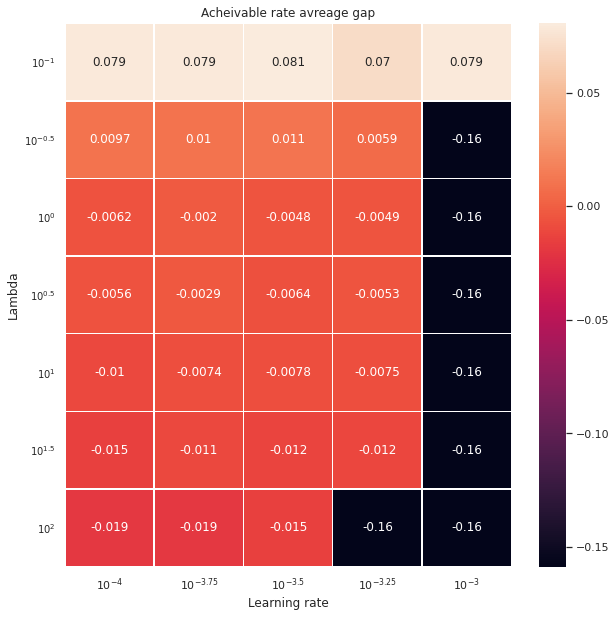

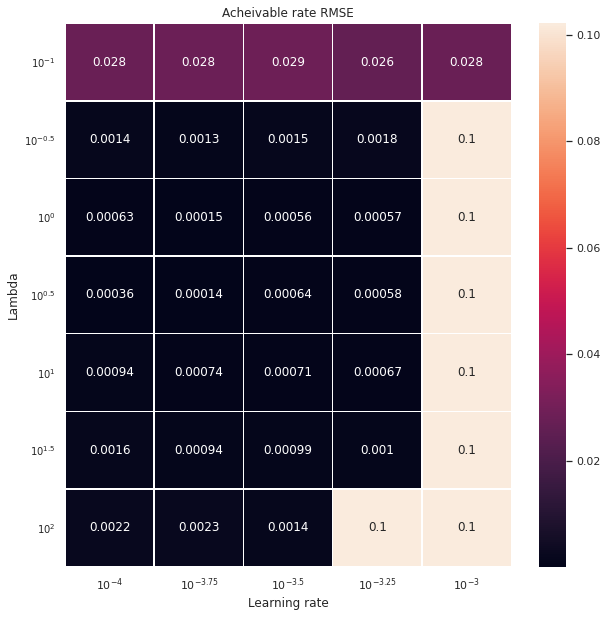

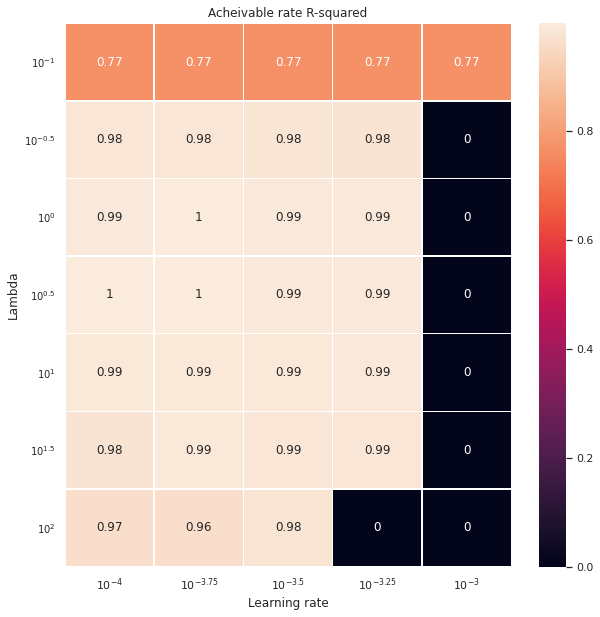

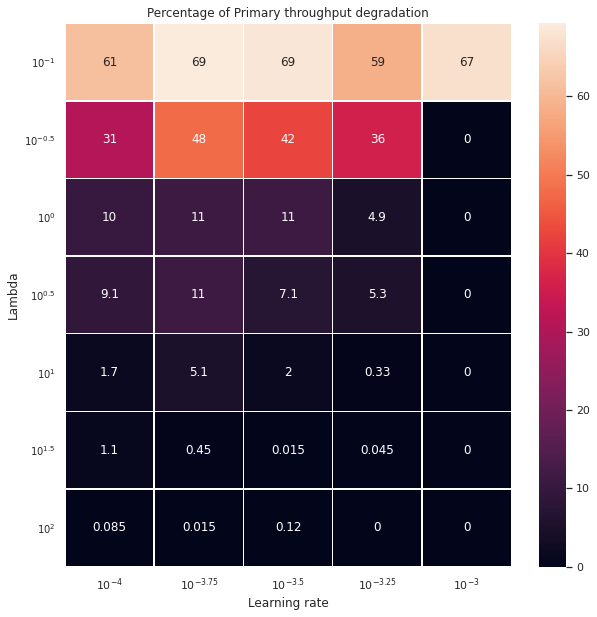

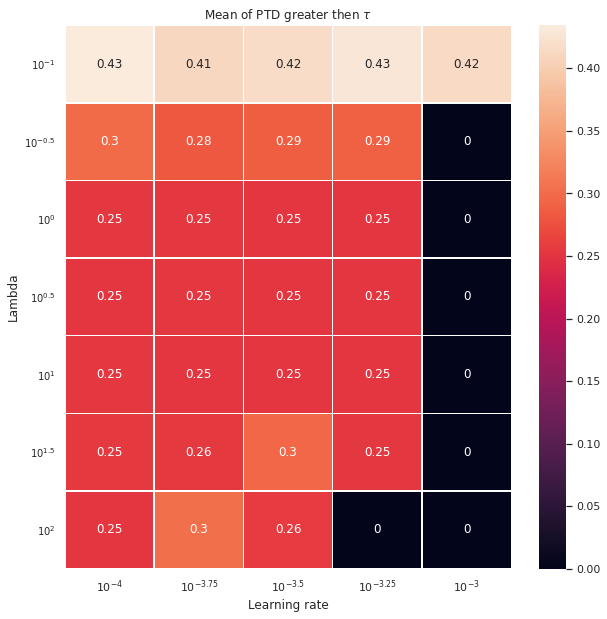

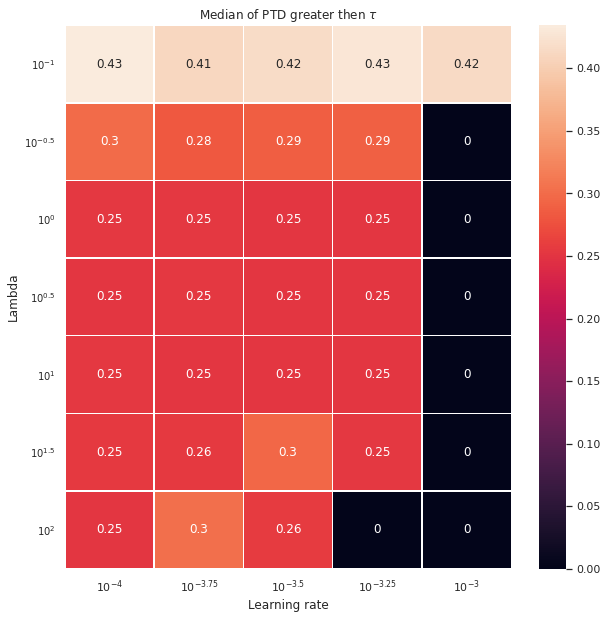

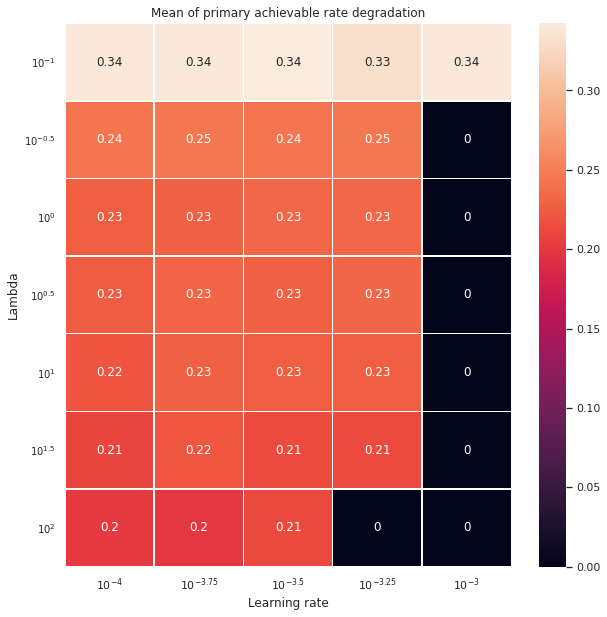

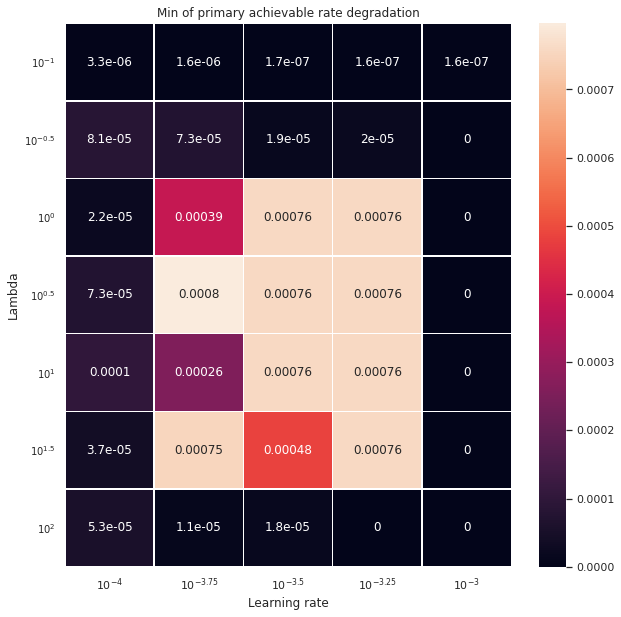

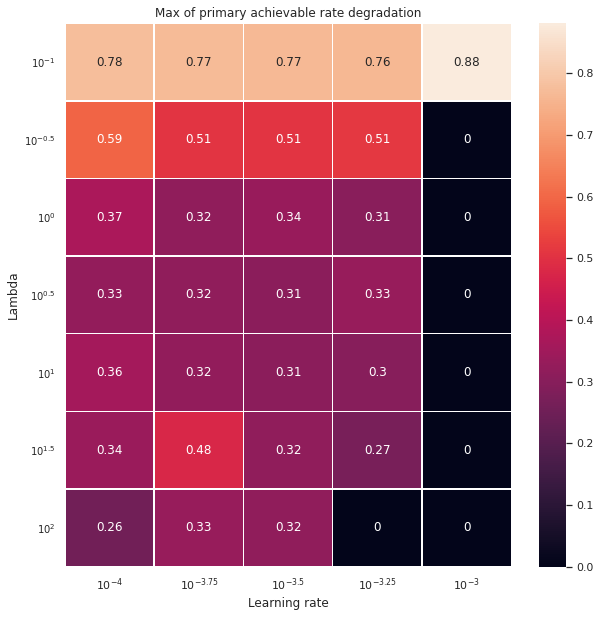

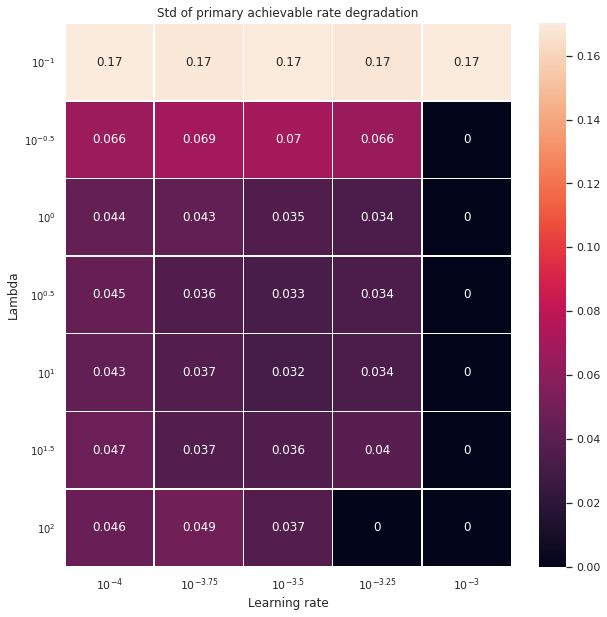

In [114]:
from matplotlib.colors import ListedColormap

def results_grid(title, data, lambda_label, lr_label):
  #df = pd.DataFrame(data, list(lambda_label.keys()), list(lr_label.keys()))
  df = pd.DataFrame(data, lambda_label, lr_label)

  fig, ax = plt.subplots(figsize=(10,10))
  plt.title(title)
  ax = sns.heatmap(df, annot=True, linewidths=.5, ax=ax)
  plt.ylabel('Lambda')
  plt.xlabel('Learning rate')
  ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 10)
  plt.savefig('/Results/Grid color/'+title, bbox_inches='tight')


################ Acheivable rate results ################

results_grid('Acheivable rate avreage gap',debit_gap_all, LD, LR)
results_grid('Acheivable rate RMSE', debit_rmse_all, LD, LR)
#results_grid('Acheivable rate NRMSE', debit_nrmse_all, LD, LR)
results_grid('Acheivable rate R-squared', debit_r2_all, LD, LR)

################ QoS results ################
results_grid('Percentage of Primary throughput degradation',viloated_tau_all, LD, LR)
results_grid(r'Mean of PTD greater then $\tau$', ard_mean_all, LD, LR)
results_grid(r'Median of PTD greater then $\tau$', ard_median_all, LD, LR)

################ Primary achievable rate degradation results ################

results_grid('Mean of primary achievable rate degradation',pdd_vmean_all, LD, LR)
results_grid('Min of primary achievable rate degradation',pdd_vmin_all, LD, LR)
results_grid('Max of primary achievable rate degradation',pdd_vmax_all, LD, LR)
results_grid('Std of primary achievable rate degradation',pdd_vstd_all, LD, LR)




In [ ]:
df = pd.DataFrame(debit_gap_all, LD.keys(), LR.keys())

In [70]:
LD = {'10_-1':10**-1,'10_-0.5':10**-0.5,'10_0':10**0,'10_0.5':10**0.5,'10_1':10**1,'10_1.5':10**1.5,'10_2':10**2}

LR = {'10_-4':10**-4,'10_-3.75':10**-3.75,'10_-3.5':10**-3.5,'10_-3.25':10**-3.25,'10_-3':10**-3}


In [71]:
debit_true = dataset(x_test[:,0], x_test[:,1], x_test[:,2], x_test[:,3],x_test[:,4], x_test[:,5], x_test[:,6], x_test[:,7], y_test[:,0], np.sqrt(y_test[:,1]), np.sqrt(y_test[:,2]), np.sqrt(y_test[:,3]))

In [73]:
def CDB(x, y, debit_GT):
  sns.set(style='white')
  plt.rcParams["figure.figsize"] = (10,5)
  

  colors = ['plum', 'green', 'aqua', 'wheat', 'darkred', 'grey', 'peru', 'purple', 'black', 'red']
  m = ['P','o', 'v', '^', '<', '>', 'H', '8', 'p','s']
  marker_N = 1200
  for j in range(x.shape[0]):
    for k in range(x.shape[1]):
           sns.ecdfplot(data=x[j,k,:], label=r'Lr = '+'$'+y[k].replace('_','^{')+'}$', lw=1, ls=':', marker=m[k],markerfacecolor=colors[k], dash_capstyle='round',color = 'black', markersize=8, markevery=marker_N)
    fig = plt.figure(1)
    sns.ecdfplot(data=debit_GT[:,8], label='Bruteforce', lw=1, ls=':', marker='p',markerfacecolor='red', dash_capstyle='round',color = 'black', markersize=8, markevery=marker_N)
  
    plt.grid()
    plt.xlabel("Achievable rate")
    
    plt.title(r'Cumulative distribution function '+"(lambda = "+'$'+list(LD.keys())[j].replace('_','^{')+'}$'+')',fontweight="bold")
    
    lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
            fancybox=True, shadow=True, ncol=3)
    fig.savefig('/content/drive/MyDrive/Colab Notebooks/CodeVF/Results_WN/CDB/CDB_'+list(LD.keys())[j]+'.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
    fig.show()
    plt.pause(1)

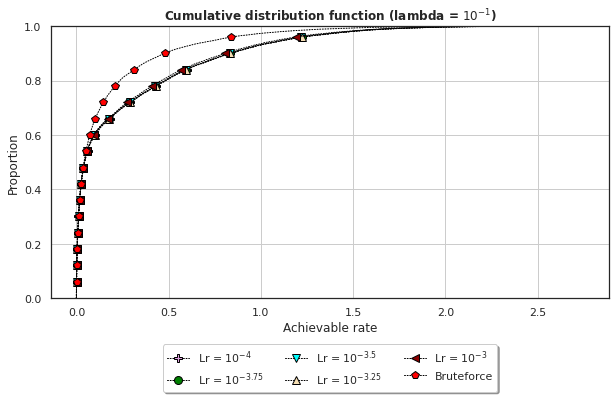

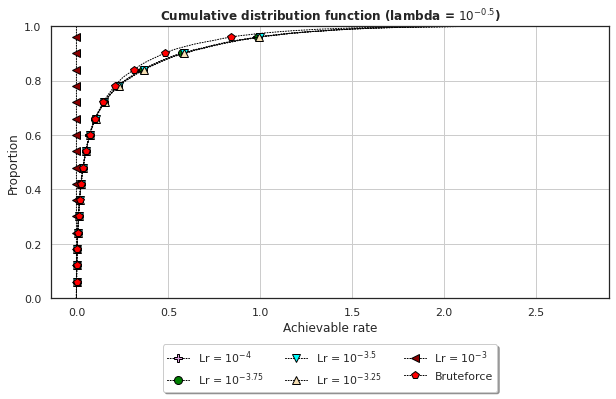

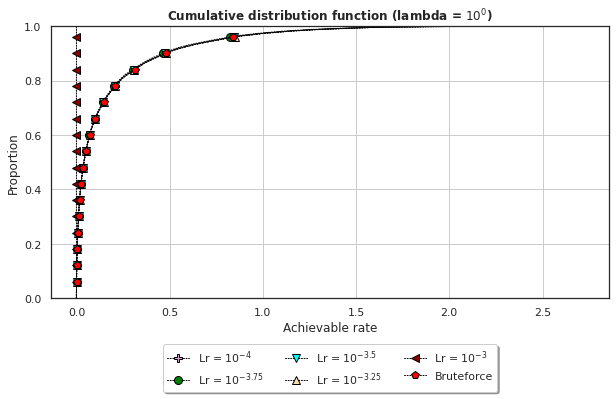

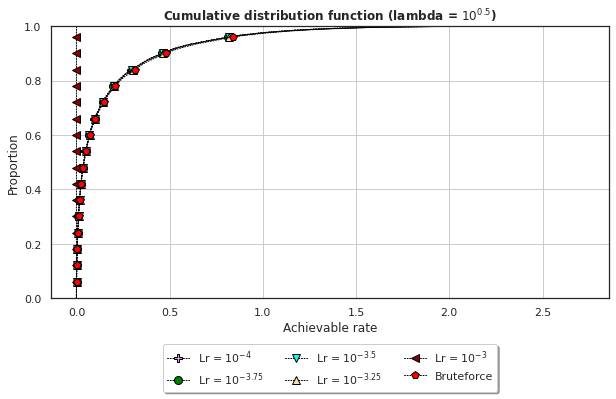

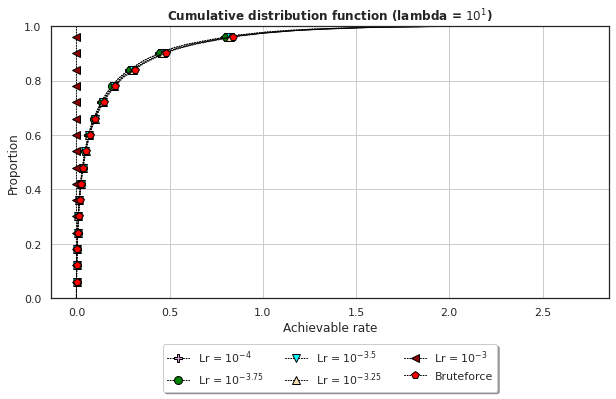

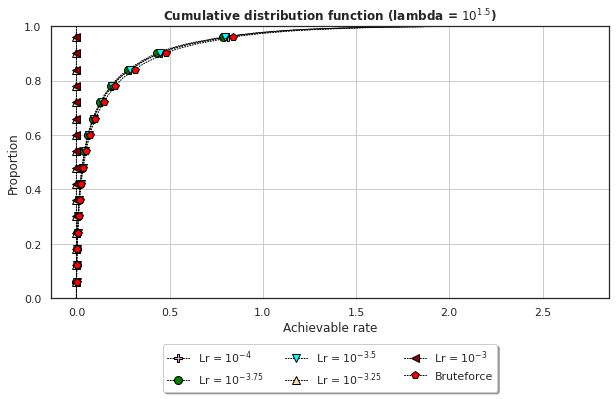

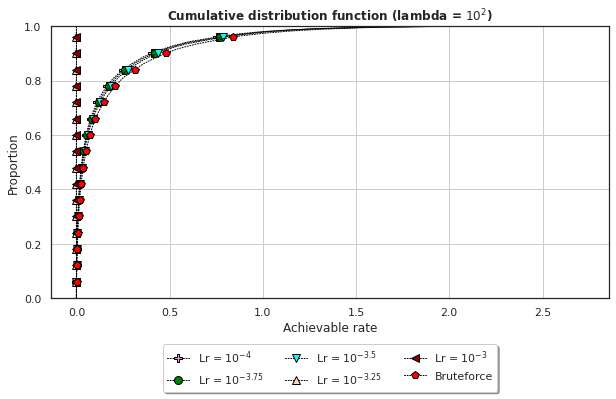

In [75]:
CDB(np.array(predicted_debit_all), list(LR.keys()),debit_true)

In [98]:
LD = {'10_-1':10**-1,'10_-0.5':10**-0.5,'10_0':10**0,'10_0.5':10**0.5,'10_1':10**1,'10_1.5':10**1.5,'10_2':10**2}

LR = {'10_-4':10**-4,'10_-3.75':10**-3.75,'10_-3.5':10**-3.5,'10_-3.25':10**-3.25,'10_-3':10**-3}


Loss_temp, Loss_data = [], []

Throughput_temp, Throughput_data = [], []

V_Qos_temp, V_Qos_data = [], []

Rp_degradation_temp, Rp_degradation_data = [], []


for ld_k in LD.keys():
  for lr_k in LR.keys():
  
    history = np.load('/content/drive/MyDrive/Colab Notebooks/CodeVF/model_train_WN/Lambda = '+ld_k+'/history/'+lr_k+'.npy',allow_pickle='TRUE').item()
    
    Loss_temp.append(history['loss'])
    Throughput_temp.append(history['throughput'])# Achievable_Rate
    V_Qos_temp.append(history['Primary_ARDP'])# Primary_ARDP
    Rp_degradation_temp.append(history['Primary_Achievable_Rate_Degradation']) #
  
  Loss_data.append(Loss_temp)
  Throughput_data.append(Throughput_temp)
  V_Qos_data.append(V_Qos_temp)
  Rp_degradation_data.append(Rp_degradation_temp)

  Loss_temp, Throughput_temp, V_Qos_temp, Rp_degradation_temp  = [], [], [], []
   

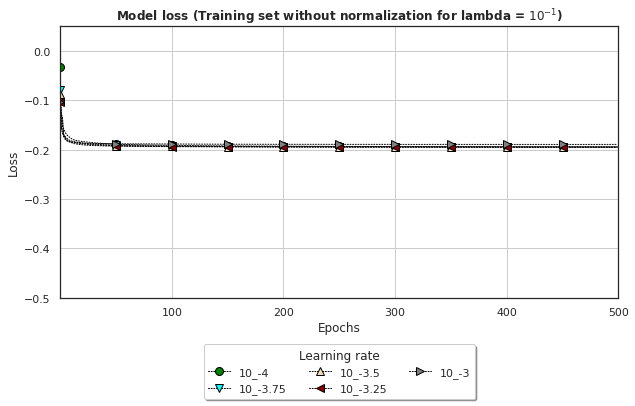

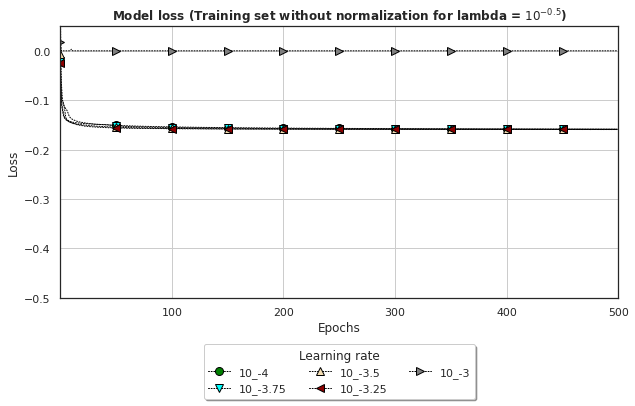

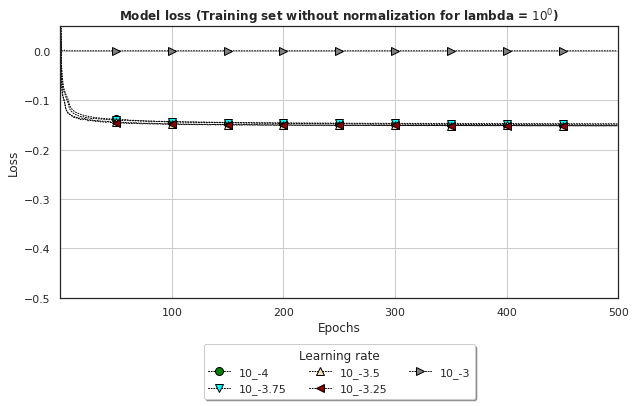

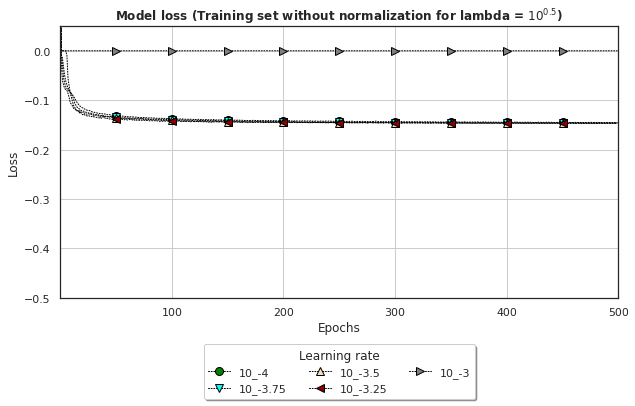

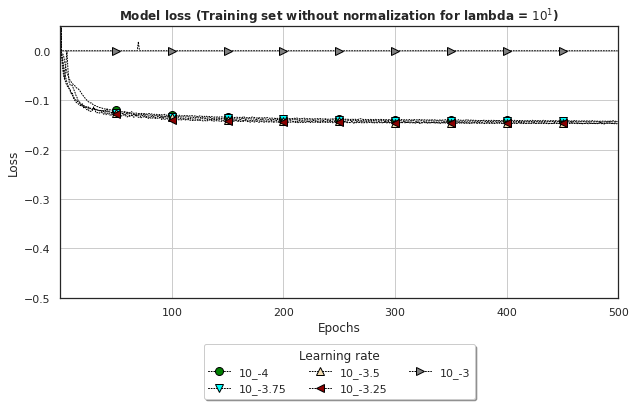

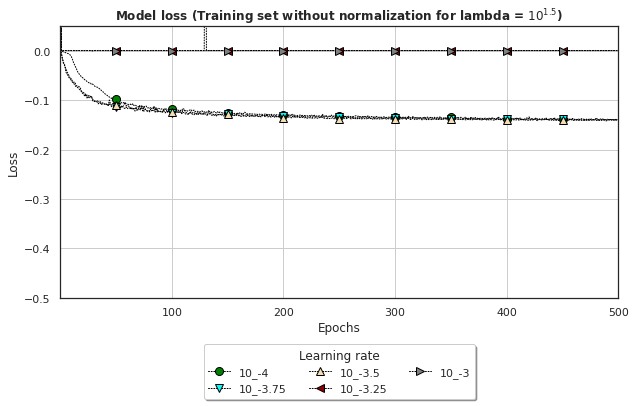

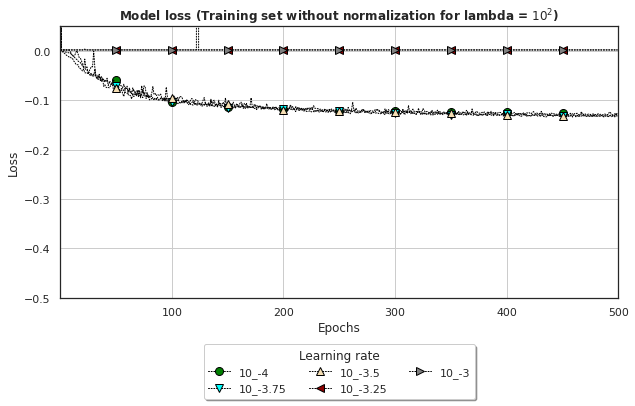

In [99]:
plot_learning_curve('Model loss (Training set without normalization for lambda = ', Loss_data, 'Loss', [0.1,500], [-0.50,0.05], LD, LR, '/Results_WN/Learning_curve2/Loss/Training_Loss/')

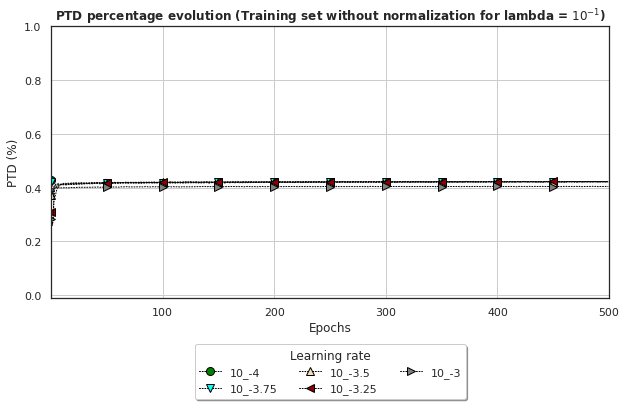

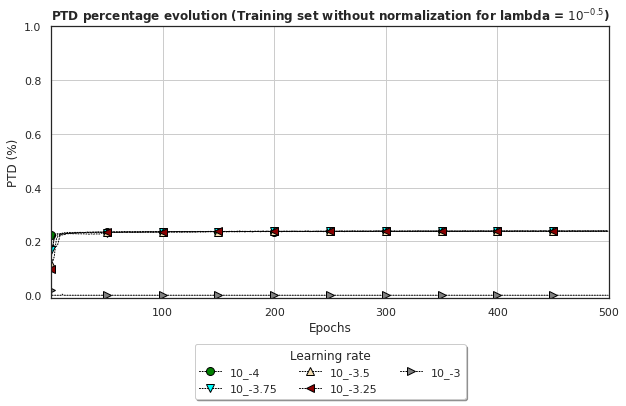

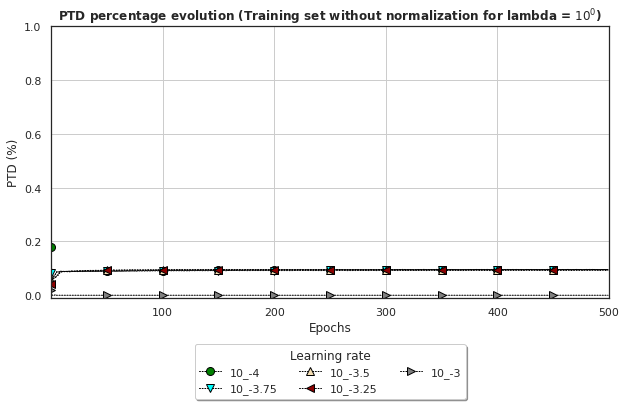

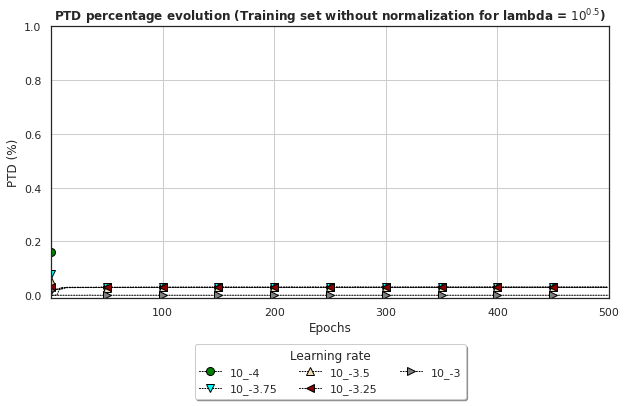

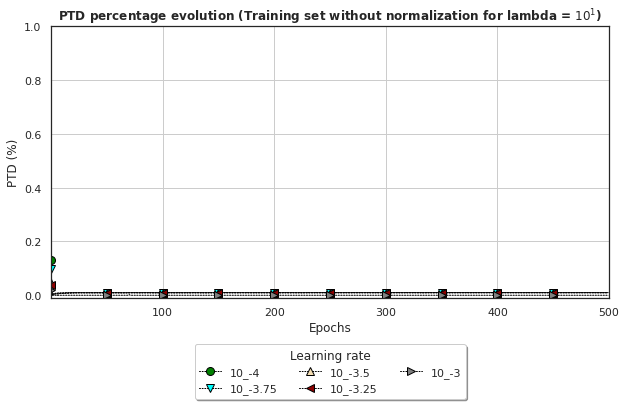

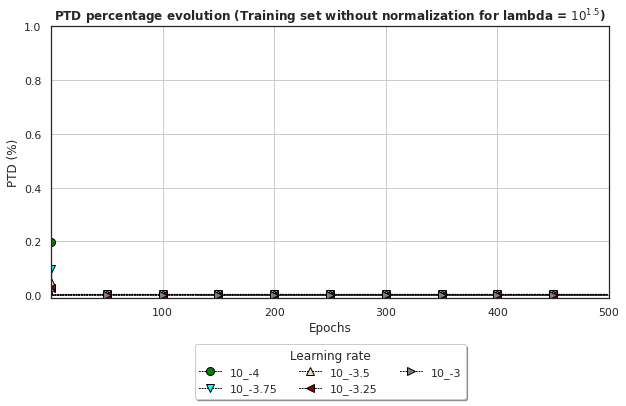

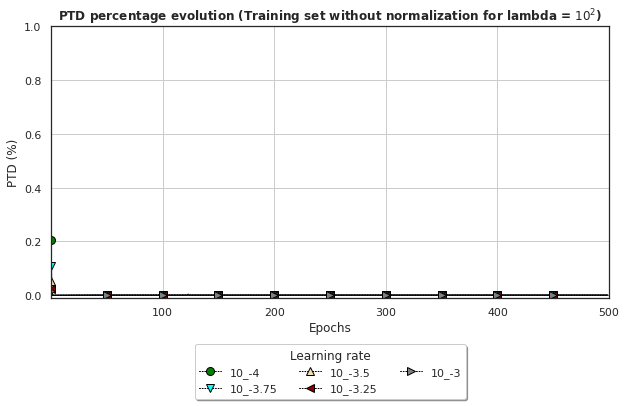

In [100]:
plot_learning_curve('PTD percentage evolution (Training set without normalization for lambda = ', V_Qos_data, 'PTD (%)', [0.1,500], [-0.01,1], LD, LR, '/Results_WN/Learning_curve2/PTD/Training_PPTD/')

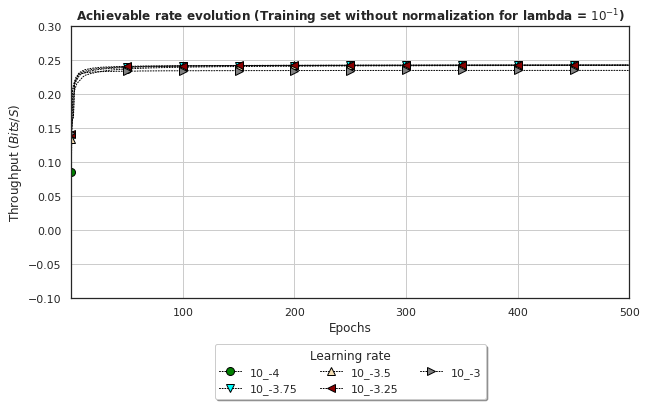

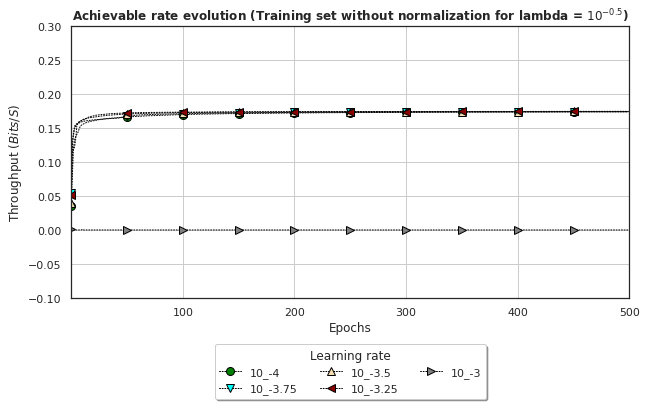

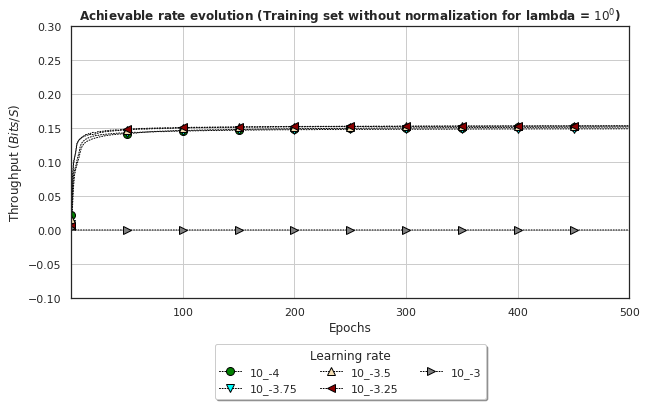

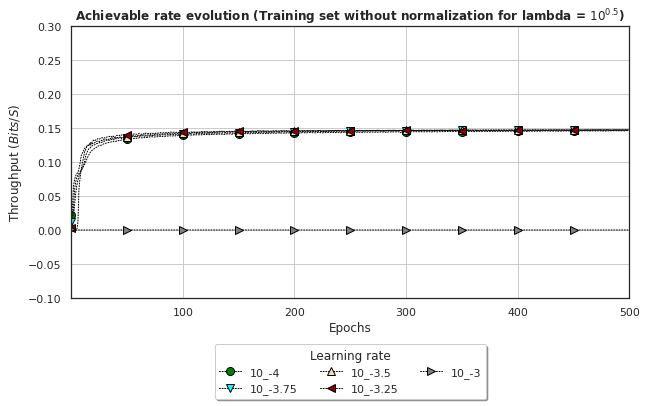

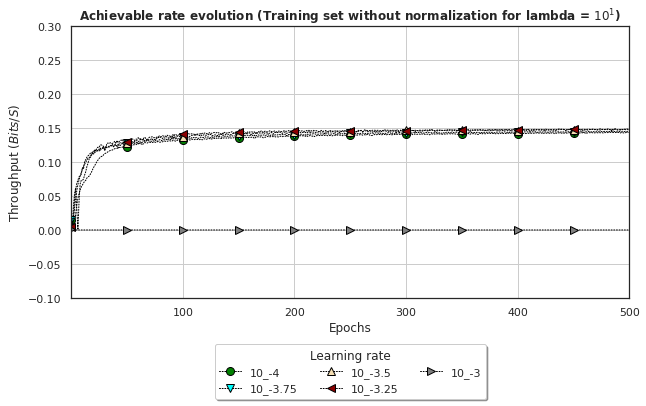

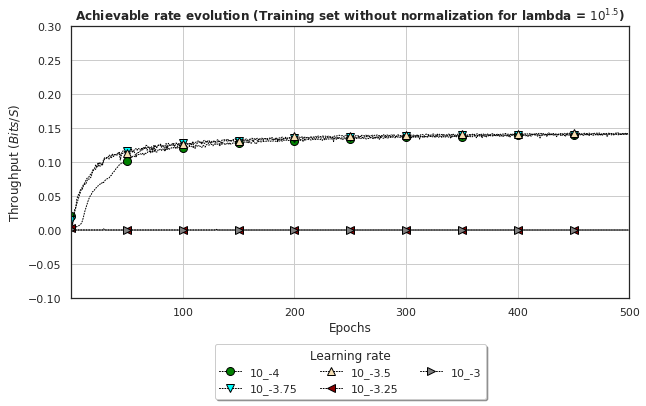

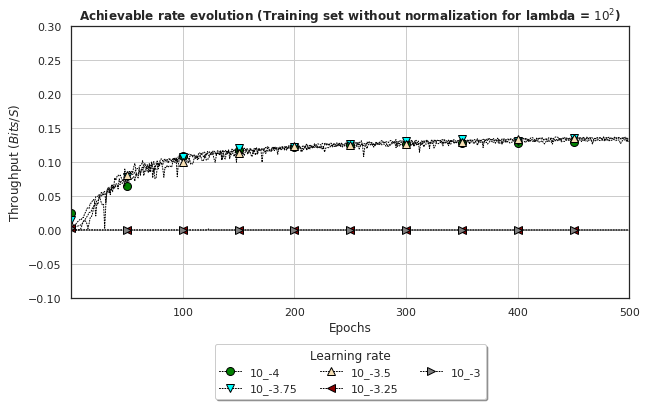

In [101]:
plot_learning_curve('Achievable rate evolution (Training set without normalization for lambda = ', Throughput_data, r'Throughput $(Bits/S)$', [0.1,500], [-0.1,0.3], LD, LR,'/Results_WN/Learning_curve2/Debit/Training_Debit/')

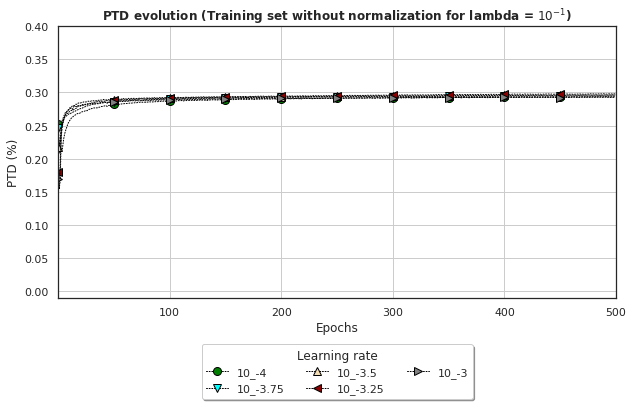

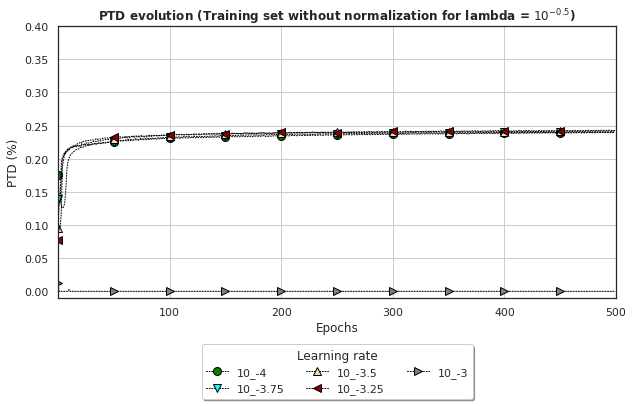

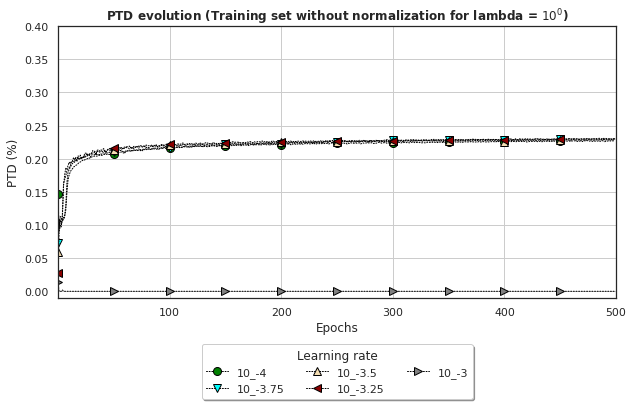

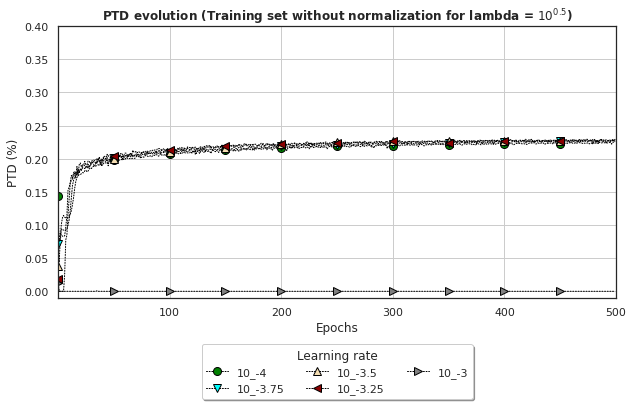

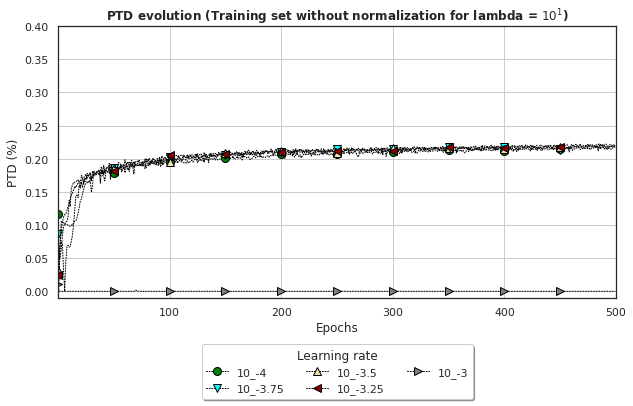

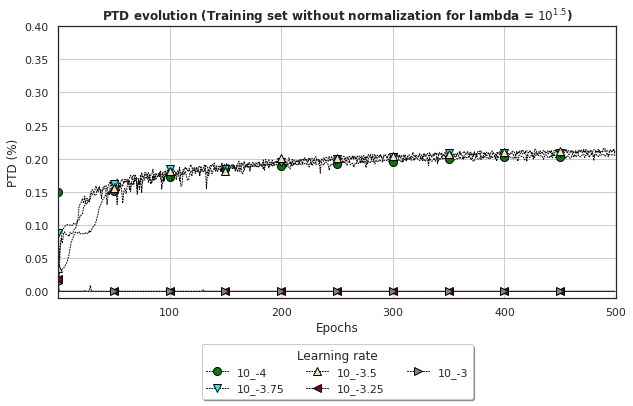

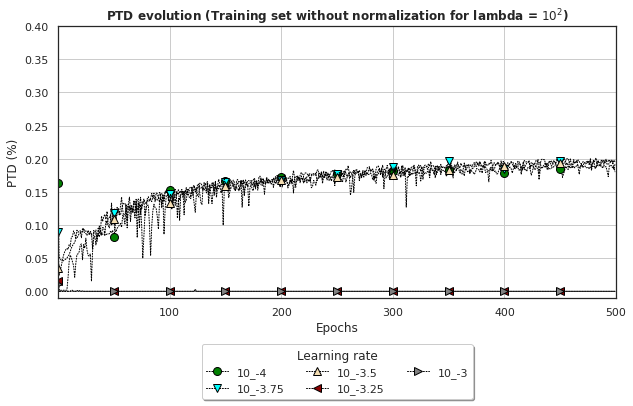

In [102]:
plot_learning_curve('PTD evolution (Training set without normalization for lambda = ', Rp_degradation_data, 'PTD (%)', [0.1,500], [-0.01,0.4], LD, LR, '/Results_WN/Learning_curve2/Primary_Degradation/Training_PTD/')

In [ ]:
'''
  plots('Qos violation evolution (Validation set with '+lambda_label[i]+')', 'QoS violation (%)', d_val_vqos_history, [0.1,500])

  plots('Achievable rate evolution (Validation set with '+lambda_label[i]+')', r'Throughput $(Bits/S)$', d_val_throughput_history, [0.1,500])
  
  plots_losses('Model loss (Validation set with normalization for '+lambda_label[i]+')', 'Loss',d_val_loss_history, [0.1,500], [-0.20,0.20])
   
 # plots('Primary achievable rate degradation (Validation set with normalization for '+lambda_label[i]+')', 'Primary achievable rate degradation (%)', d_val_rp_degradation_history, [0.1,500])
'''

In [ ]:
qos_count_train = qos_constraint(predictions1[:,0], predictions1[:,1], predictions1[:,2], x_train[:,0], x_train[:,1], x_train[:,4], x_train[:,6])
qos_count_test = qos_constraint(predictions2[:,0], predictions2[:,1], predictions2[:,2], x_test[:,0], x_test[:,1], x_test[:,4], x_test[:,6])

In [ ]:
qos_mean_train, qos_median_train = QoS_stats(predictions1[:,0], predictions1[:,1], predictions1[:,2], x_train[:,0], x_train[:,1], x_train[:,4], x_train[:,6])
qos_mean_test, qos_median_test = QoS_stats(predictions2[:,0], predictions2[:,1], predictions2[:,2], x_test[:,0], x_test[:,1], x_test[:,4], x_test[:,6])
print('\033[1m' +'train set results : \n')
print('\033[0m'+'mean of qos violation: ', qos_mean_train*100)
print('median of qos violation: ', qos_median_train*100)
print('\n')
print('\033[1m' +'test set results : \n')
print('\033[0m'+'mean of qos violation: ', qos_mean_test*100)
print('median of qos violation: ', qos_median_test*100)

train set results : 

mean of qos violation:  1.658264651747712
median of qos violation:  1.0946664374306125


test set results : 

mean of qos violation:  1.7942650128470061
median of qos violation:  1.1652791102872024


In [87]:
def V_QoS_Hist(title, Lambda_value, Lr_value, Alpha, Pr, Ps, Grp, Gpp, Gss, Gsp):
  """
    Parameters:
      title: Title of the figure.
      Lambda_value: Lambda values.
      Lr_value: Learning rate values.
      Alpha: 1D Array containing Alpha values.
      Pr: 1D Array containing Power of relay.
      Ps: 1D Array containing Power of secondary network.
      Grp: 1D Array containing Channel Gain between relay and primary receiver.
      Gpp: 1D Array containing Channel Gain between primary transmitter and primary receiver.
      Gss: 1D Array containing Channel Gain between secondarytransmitter and secondary receiver.
      Gsp: 1D Array containing Channel Gain between secondary transmitter and primary receiver.
    Returns:
      Histogram for QoS violation
  """
  sns.set(style='white')
  plt.rcParams["figure.figsize"] = (10,5)

  res = QoS_Normalized(Alpha, Pr, Ps, Grp, Gpp, Gss, Gsp)
  fig, ax = plt.subplots(1) # Creates figure fig and add an axes, ax.
  plt.title('QoS violation for lambda = '+Lambda_value+' and Lr = '+Lr_value,fontweight="bold")
  ax.hist(res, 100, density = True)
  #plt.xlim((-1,3))
  plt.grid()
  plt.yscale('log')
  plt.legend([title], loc='best')
  plt.xlabel('QoS violation percentage', fontsize=12)
  plt.ylabel('Samples', fontsize=12)

  #fig.savefig('/content/drive/MyDrive/Colab Notebooks/CodeVF/Results/QoS/histogram_'+title+'lambda_'+Lambda_value+'lr_'+Lr_value+'.png')
  fig.show() #Only shows figure 1 and removes it from the "current" stack.

def Pdd_Hist(Grp, Gpp, Gsp, Alpha, Pr, Ps, Lambda_value, Lr_value):
  """
    Parameters:
      Grp: Channel Gain between relay and primary receiver.
      Gpp: Channel Gain between primary transmitter and primary receiver. 
      Gsp: Channel Gain between secondary transmitter and primary receiver.
      Alpha: Array containing Alpha values.
      Pr: Array containing Power of relay.
      Ps: Array containing Power of secondary network.
    Returns:
      histogram for Primary debit degradation 
  """
  sns.set(style='white')
  plt.rcParams["figure.figsize"] = (10,5)

  res = pdd(Grp, Gpp, Gsp ,Alpha, Pr, Ps)
  fig, ax = plt.subplots(1) # Creates figure fig and add an axes, ax.
  plt.title('Primary achievable rate degradation distribution Lambda= '+Lambda_value+' and Lr = '+Lr_value,fontweight="bold")

  ax.hist(res, 100)
  #plt.xlim((-1,3))
  plt.grid()
  plt.yscale('log')
  plt.xlabel('Primary debit degradation percentage', fontsize=12)
  plt.ylabel('Samples', fontsize=12)
  fig.savefig('/content/drive/MyDrive/Colab Notebooks/CodeVF/Results_WN/Histogram/histogram_PTD_lambda_'+Lambda_value+'_lr_'+Lr_value+'.png')
  fig.show() 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


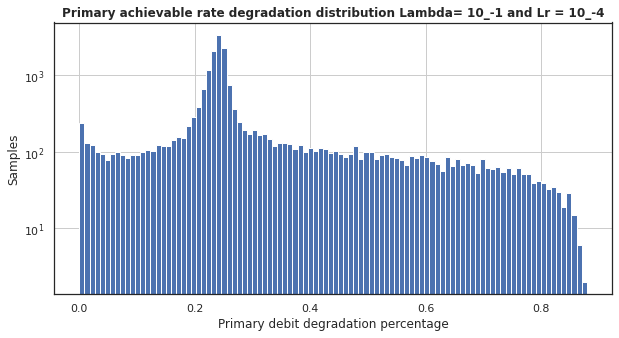

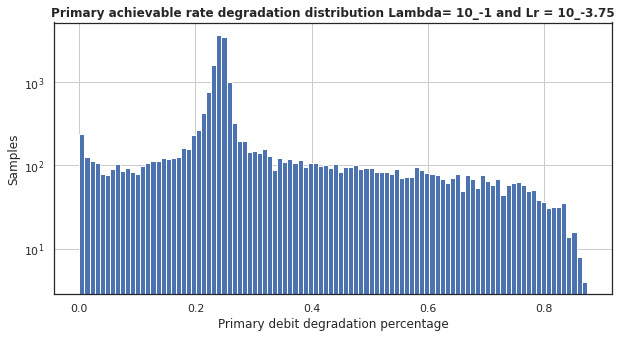

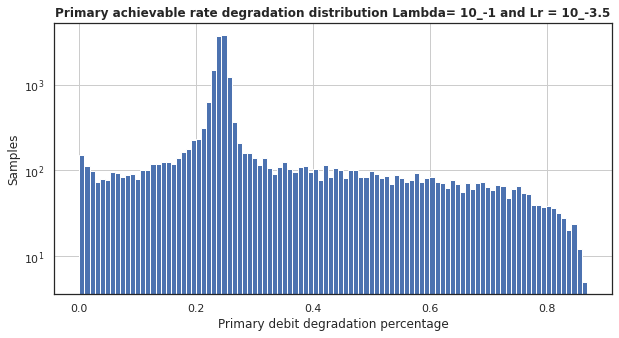

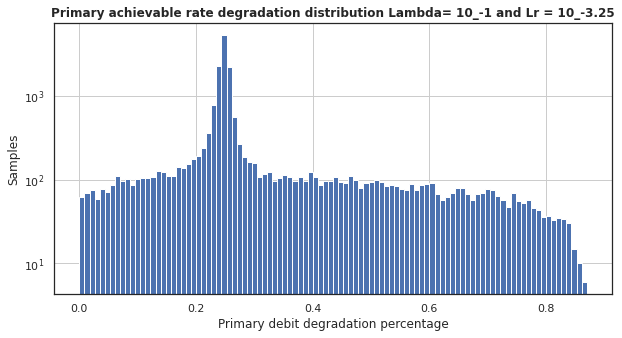

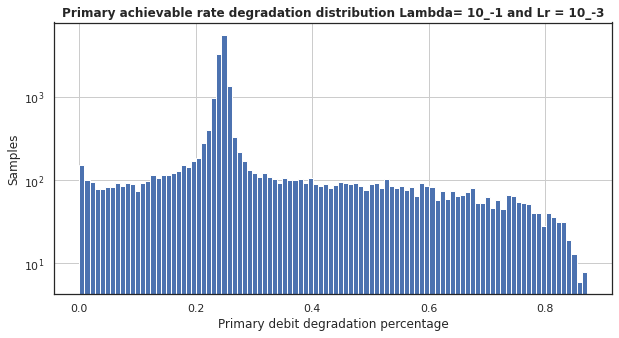

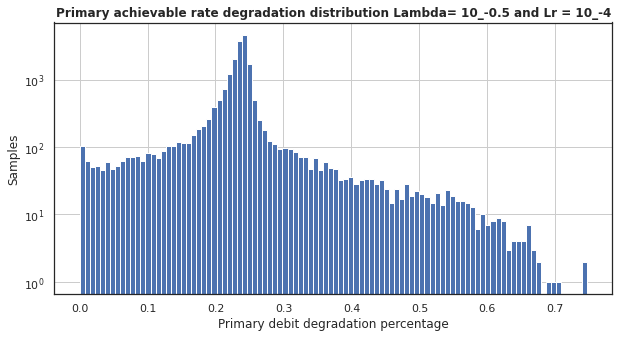

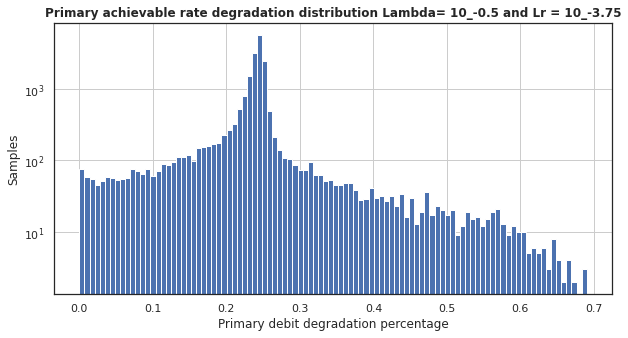

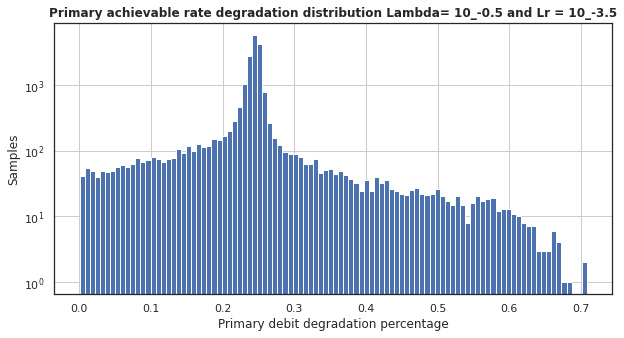

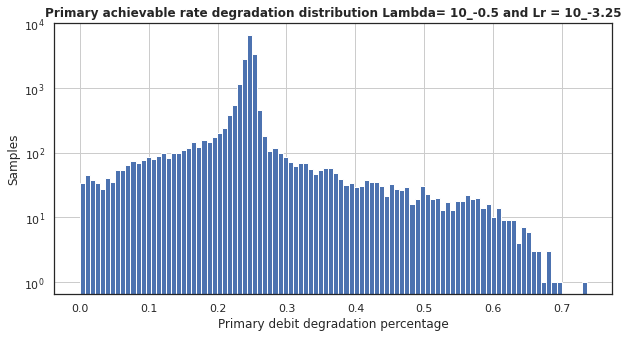

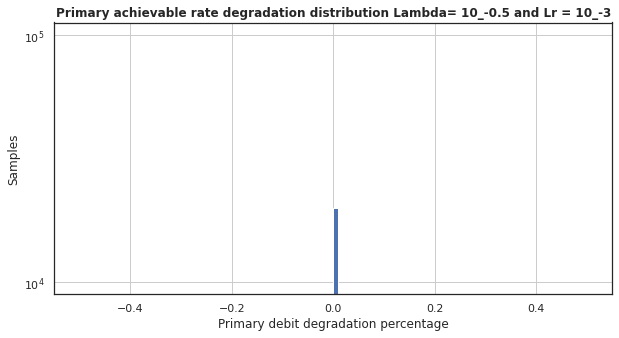

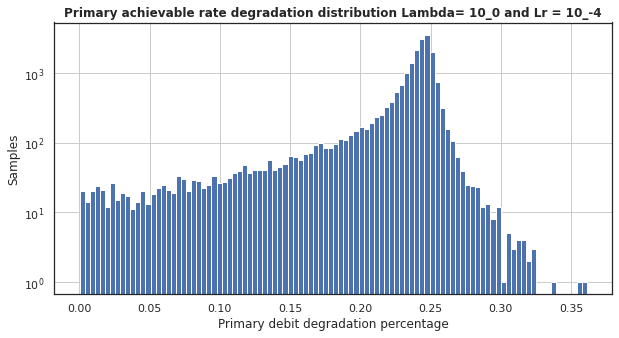

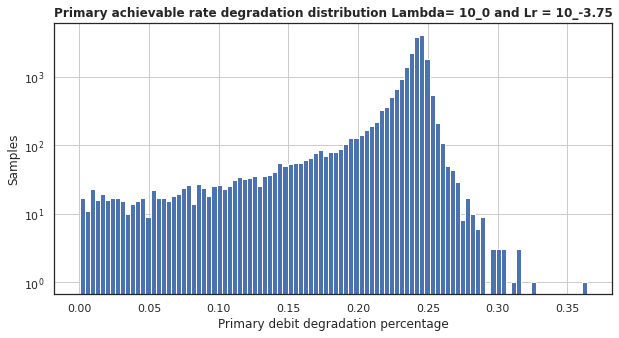

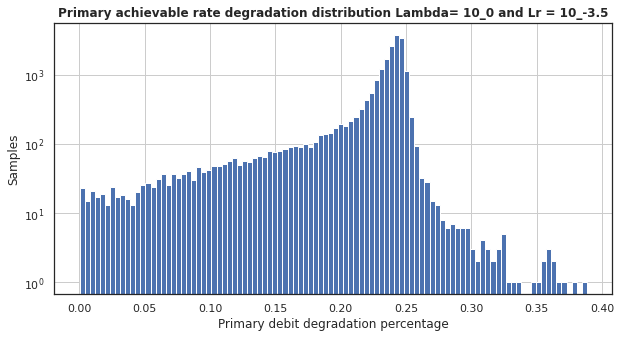

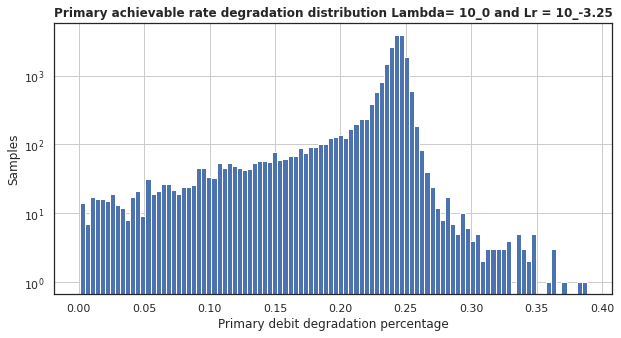

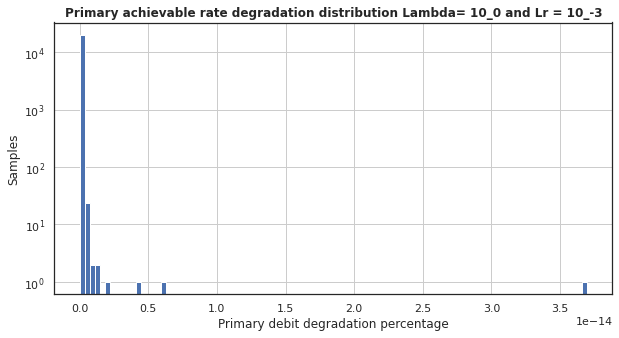

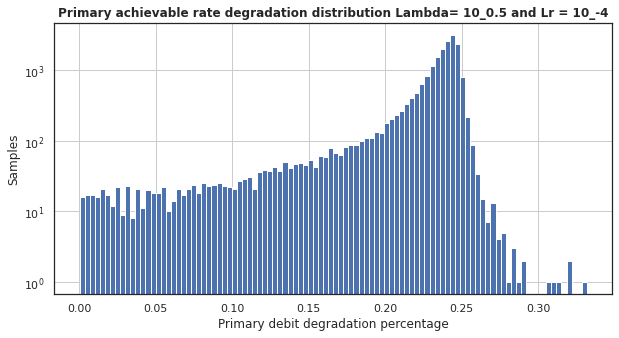

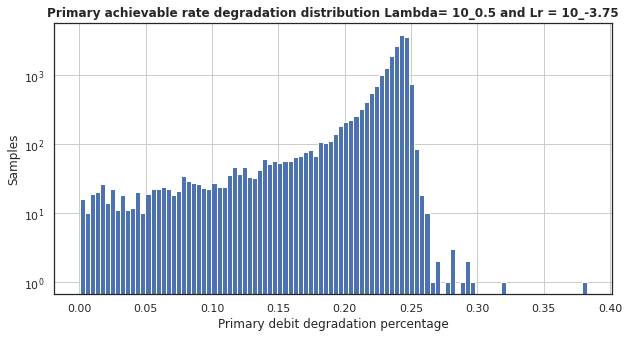

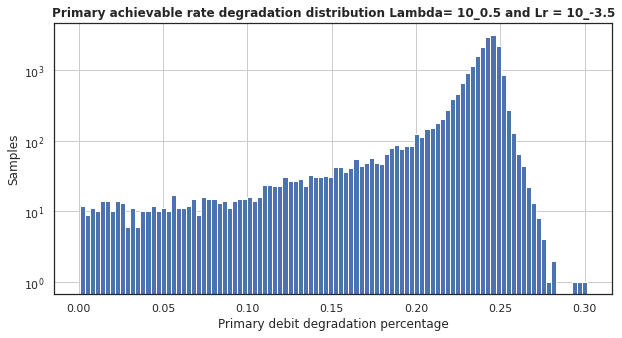

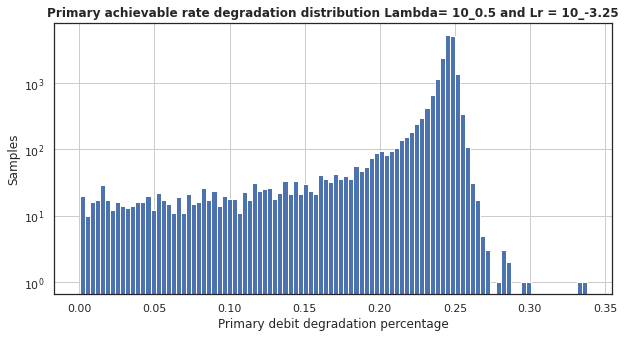

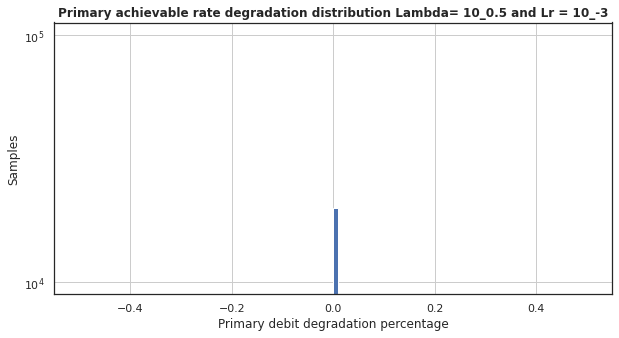

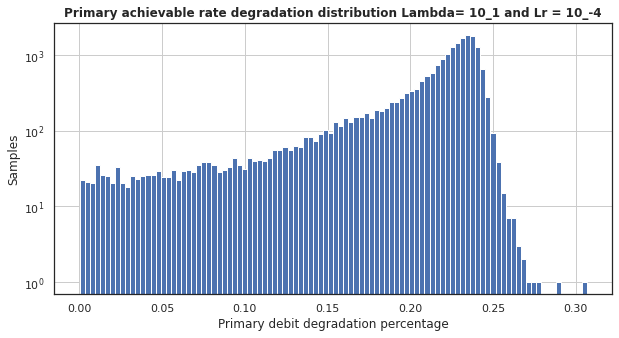

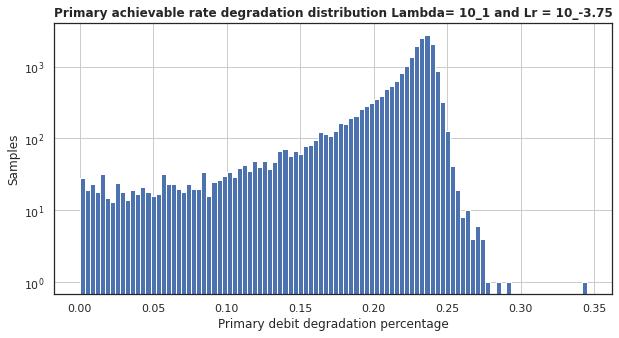

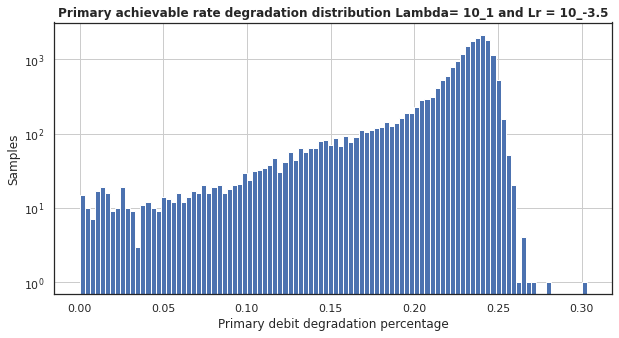

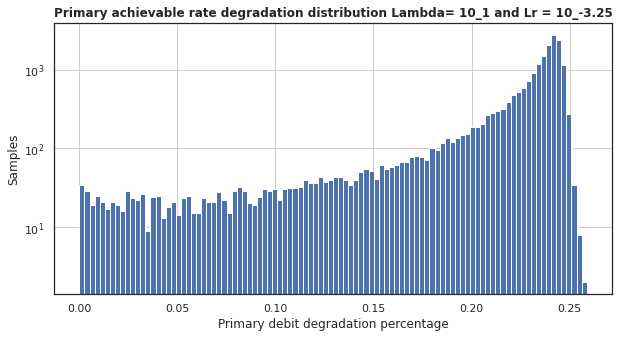

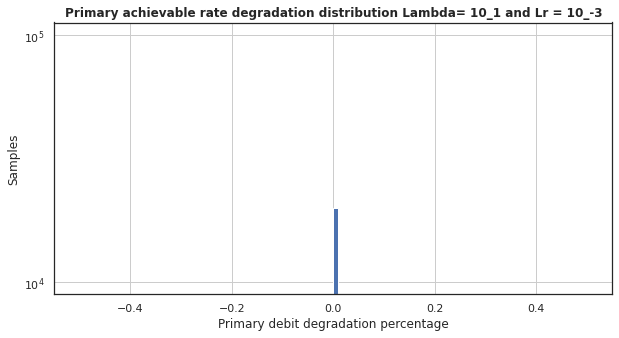

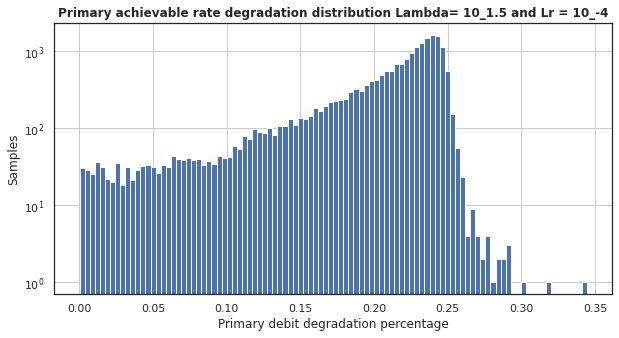

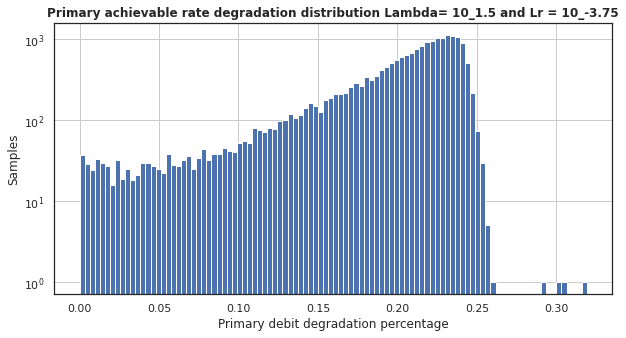

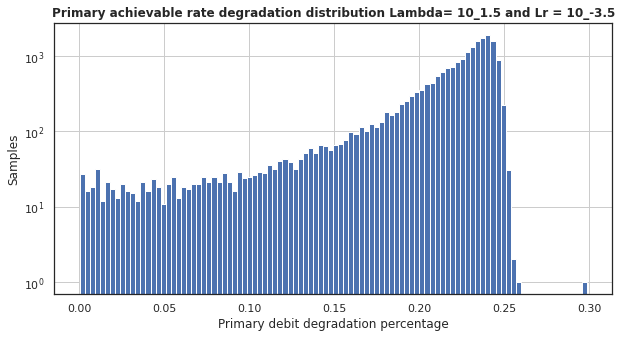

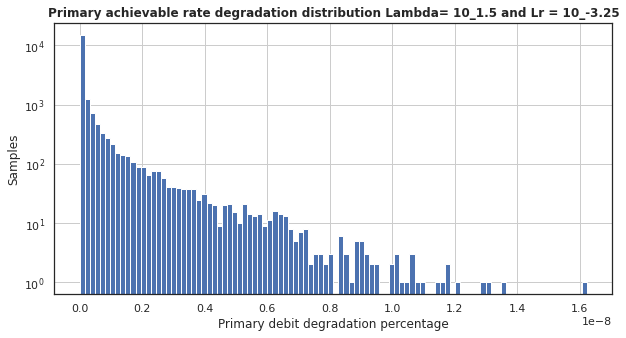

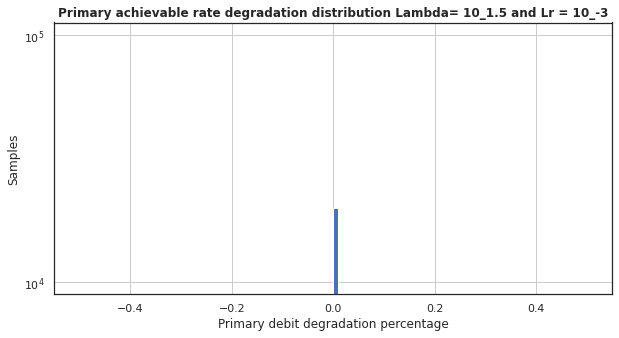

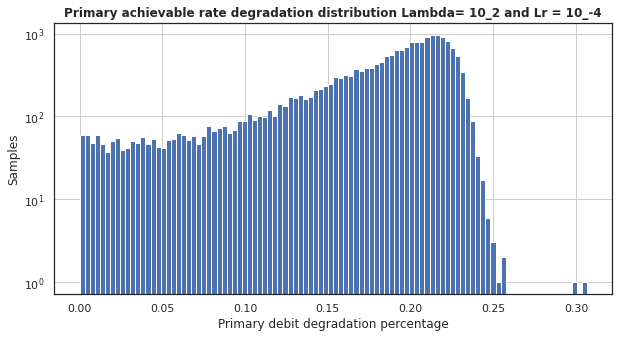

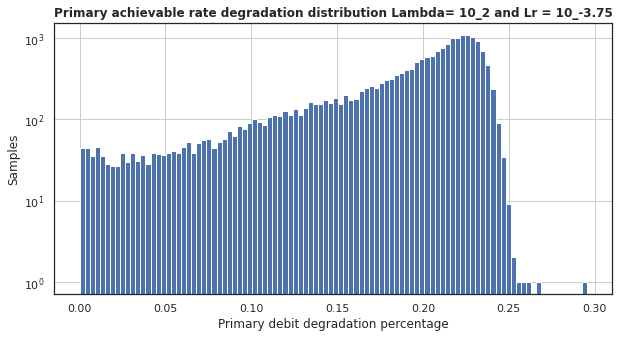

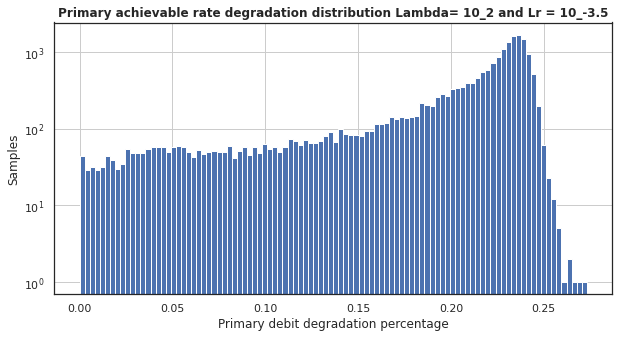

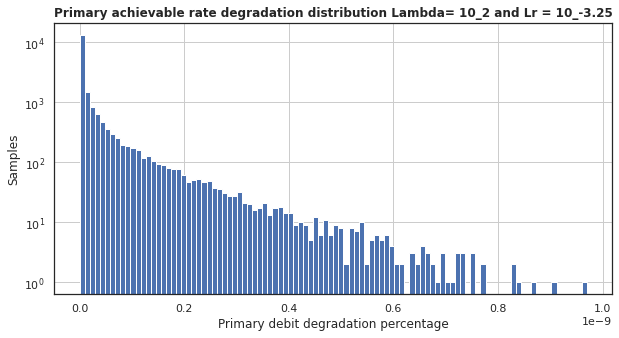

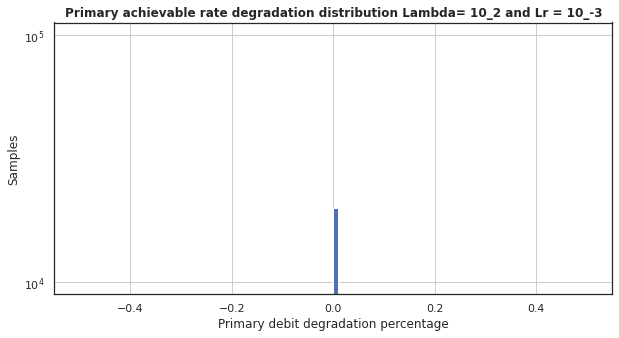

In [88]:

LD = {'10_-1':10**-1,'10_-0.5':10**-0.5,'10_0':10**0,'10_0.5':10**0.5,'10_1':10**1,'10_1.5':10**1.5,'10_2':10**2}

LR = {'10_-4':10**-4,'10_-3.75':10**-3.75,'10_-3.5':10**-3.5,'10_-3.25':10**-3.25,'10_-3':10**-3}

for ld_k in LD.keys():

  for lr_k in LR.keys():

      model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/CodeVF/model_train_WN/Lambda = '+ld_k+'/weights/'+lr_k+'.h5', custom_objects={'DF_loss':loss_DF(Lambda,tau),'Primary_Achievable_Rate_Degradation':Primary_Achievable_Rate_Degradation,'Primary_ARDP':Primary_ARD_Percentage,'throughput':Achievable_Rate(tau),'V_Qos':QoS_Violation(tau), "custom_sigmoid":custom_sigmoid})

      ##### Evaluation on train set #####
      predictions1 = model.predict(x_test)
      
      Pdd_Hist(x_test[:,0], x_test[:,1], x_test[:,6], predictions1[:,0], predictions1[:,1], predictions1[:,2], ld_k, lr_k)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


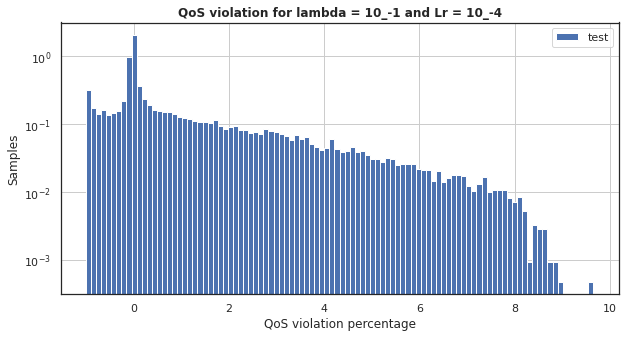

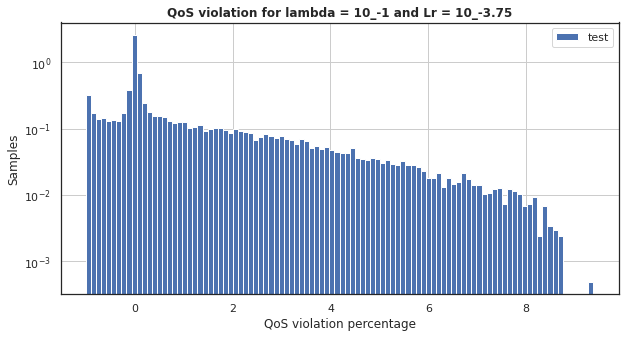

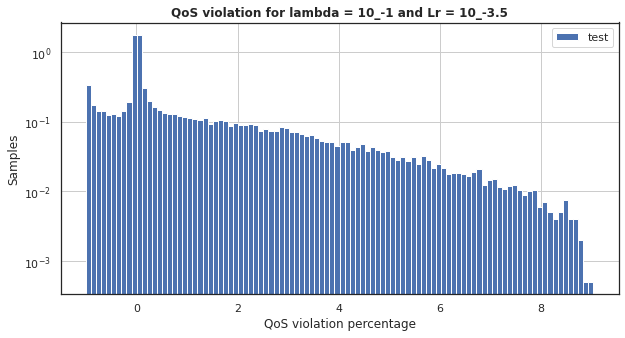

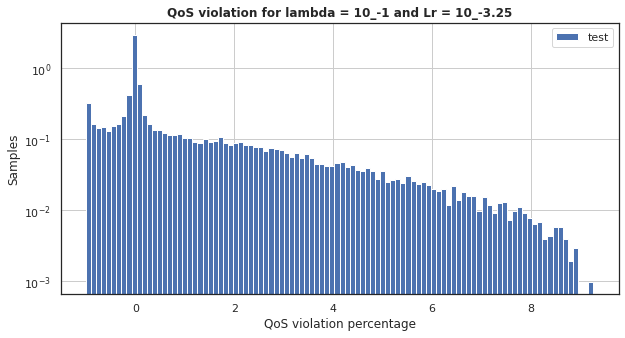

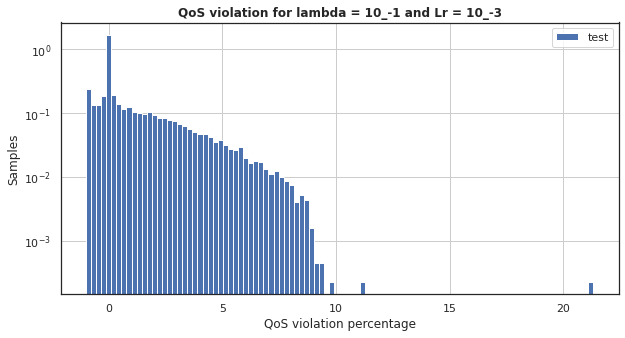

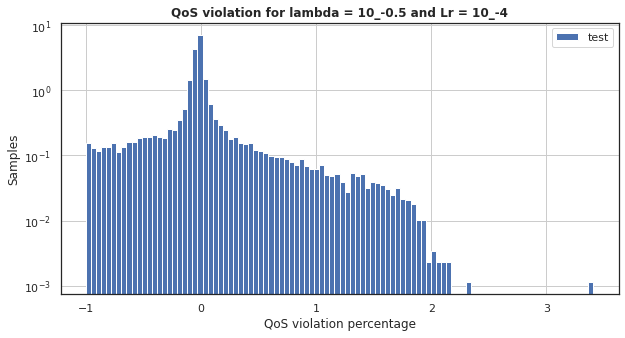

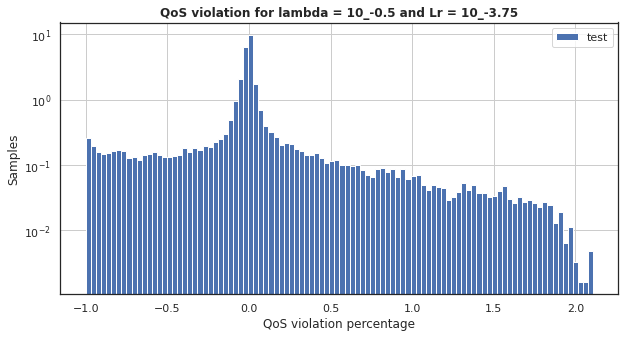

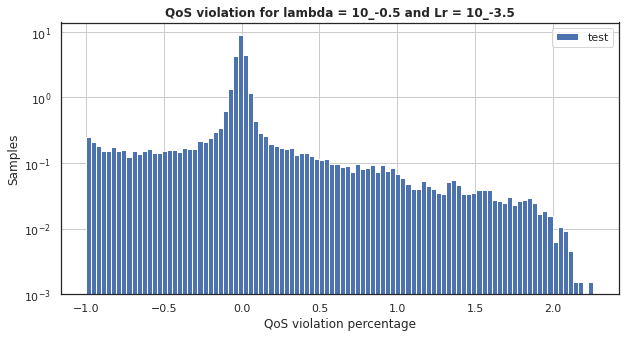

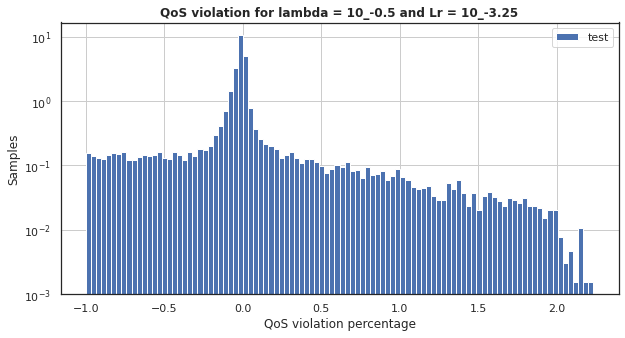

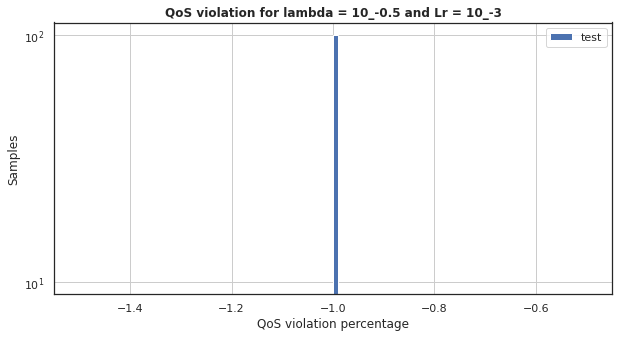

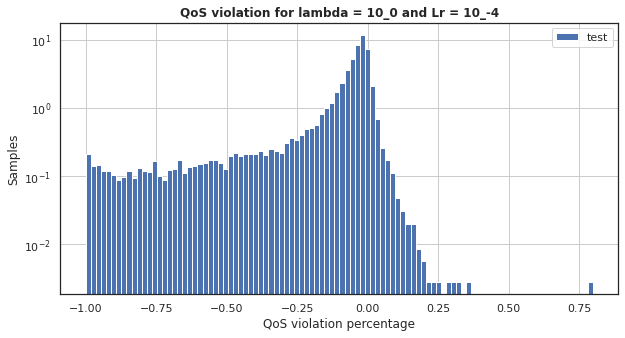

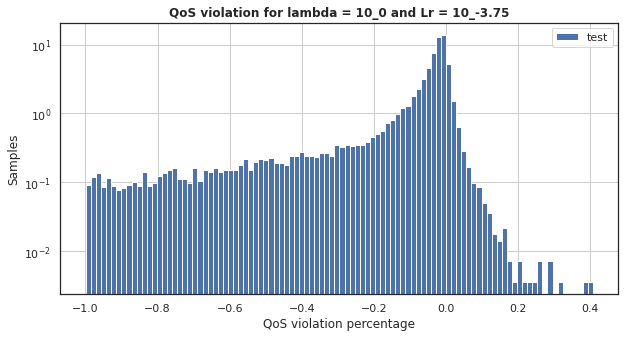

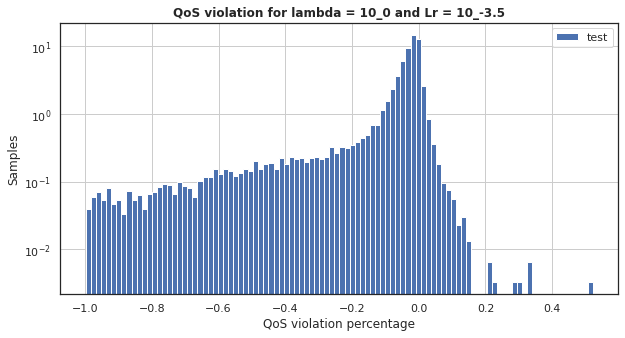

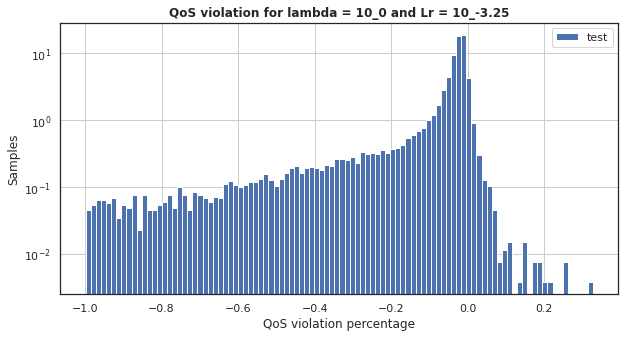

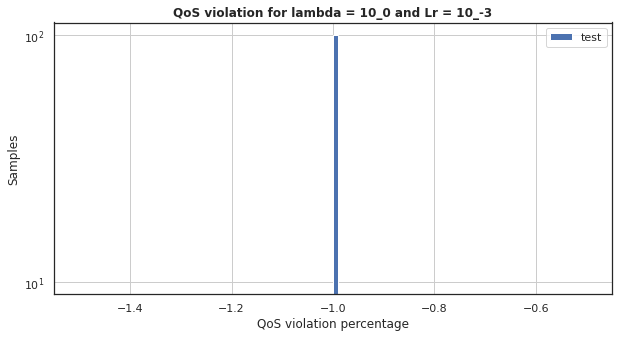

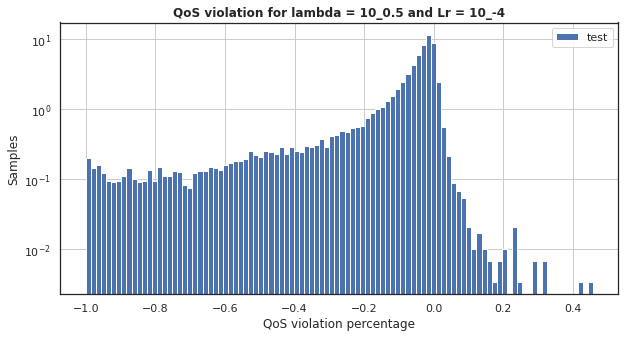

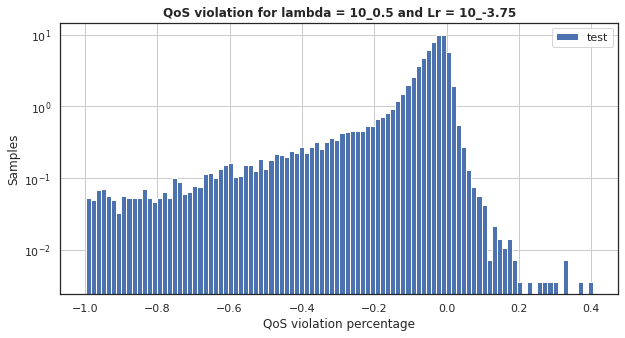

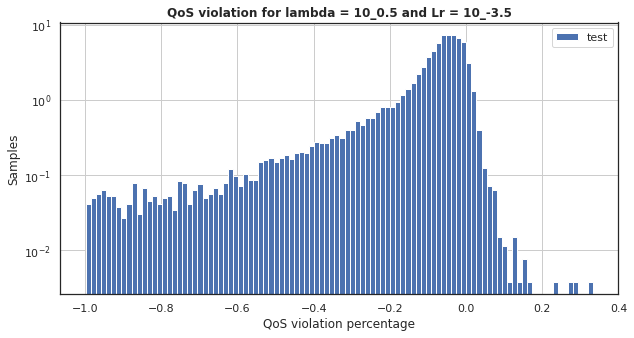

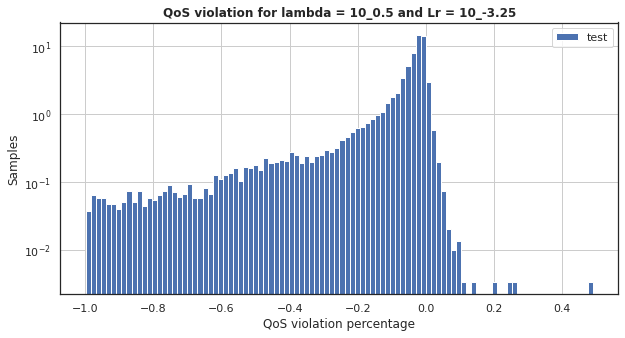

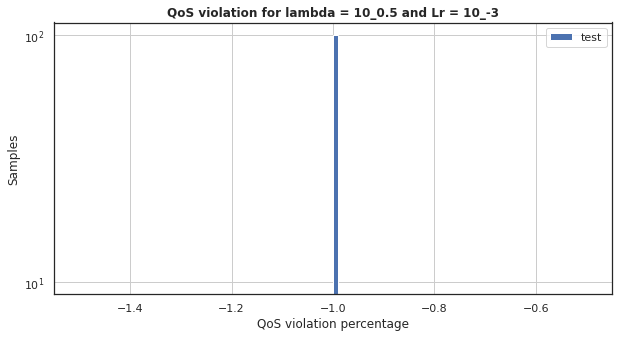

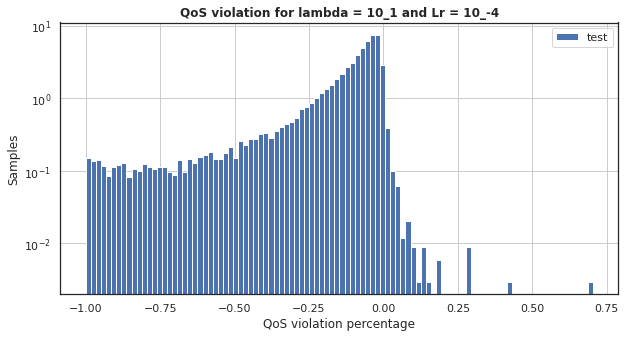

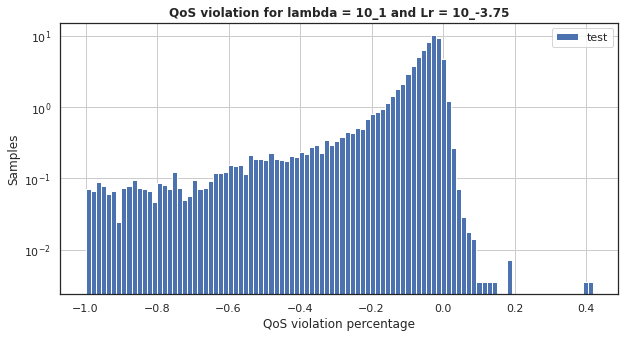

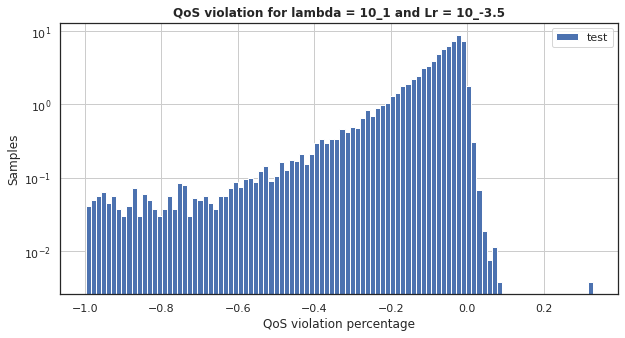

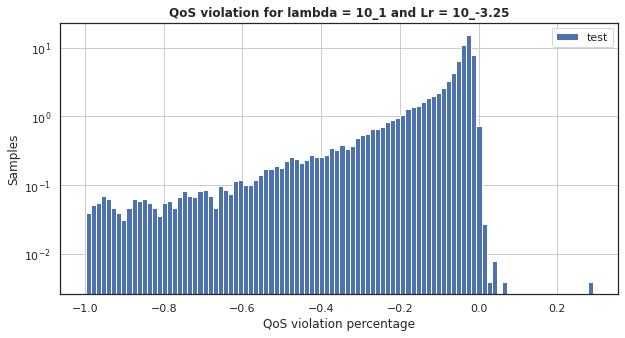

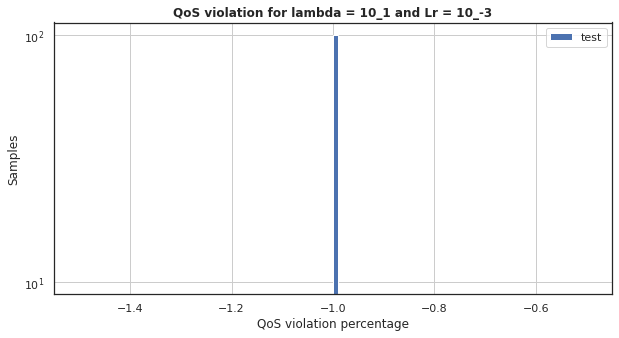

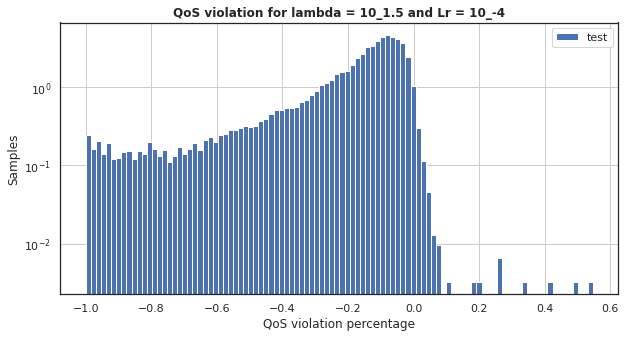

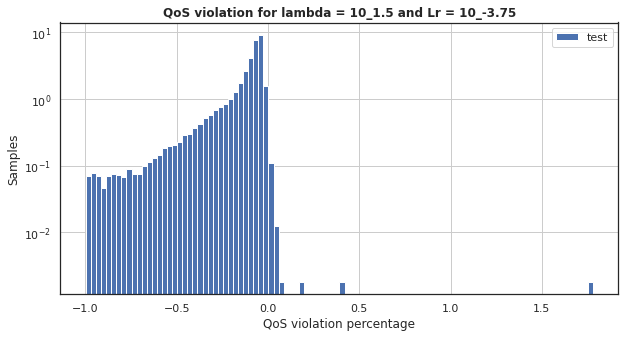

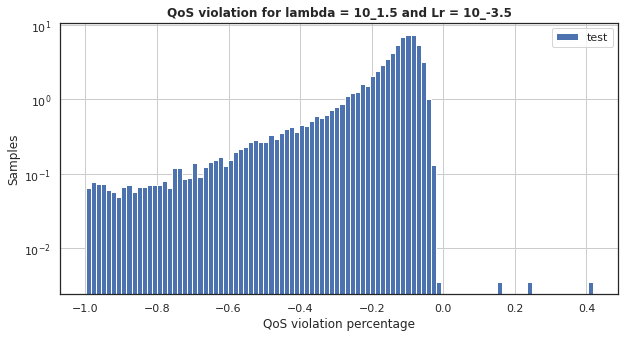

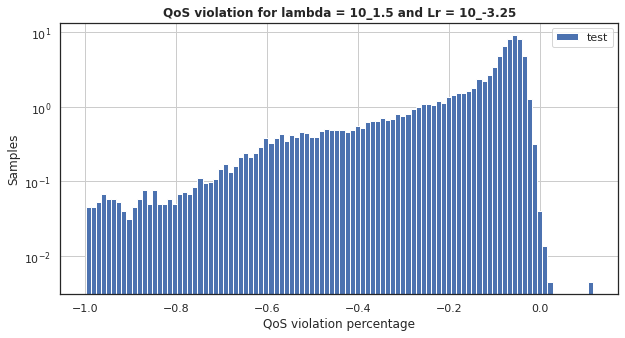

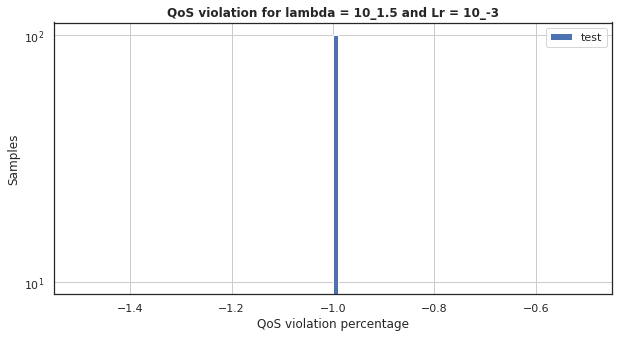

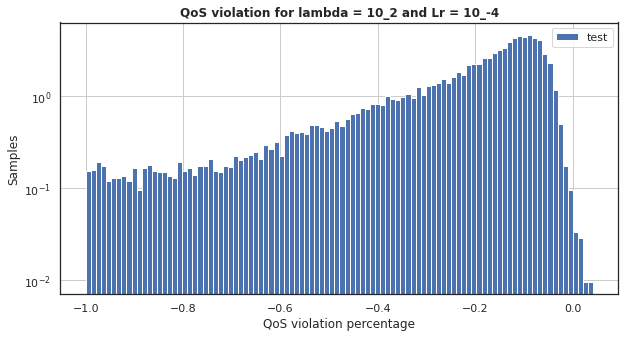

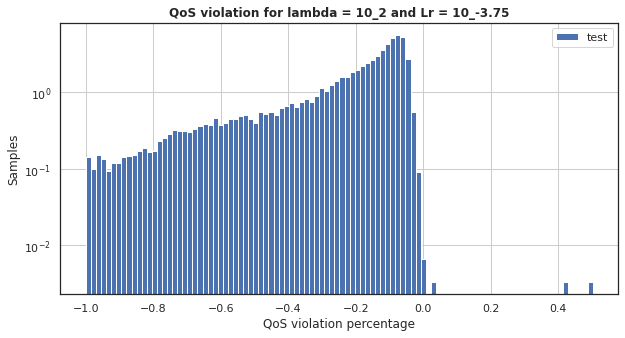

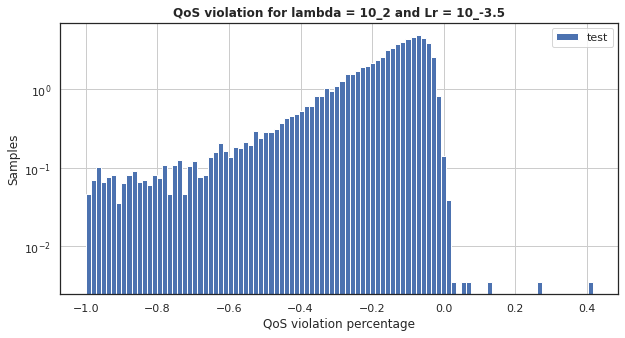

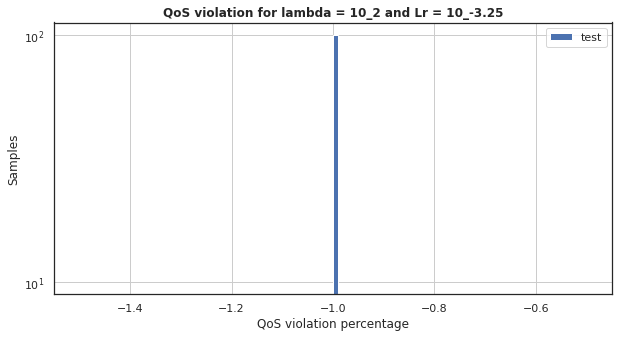

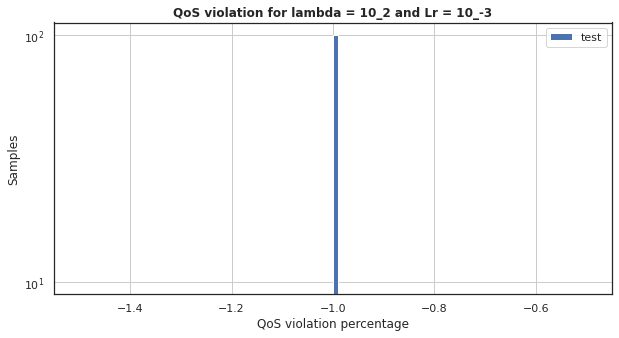

In [49]:
for ld_k in LD.keys():

  for lr_k in LR.keys():

      model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/CodeVF/model_train/Lambda = '+ld_k+'/weights/'+lr_k+'.h5', custom_objects={'DF_loss':loss_DF(Lambda,tau),'Primary_Achievable_Rate_Degradation':Primary_Achievable_Rate_Degradation,'Primary_ARDP':Primary_ARD_Percentage,'throughput':Achievable_Rate(tau),'V_Qos':QoS_Violation(tau), "custom_sigmoid":custom_sigmoid})

      ##### Evaluation on test set #####
      #predictions1 = model.predict(x_train)
      predictions2 = model.predict(x_test)
      
      #V_QoS_Hist('train', predictions1[:,0], predictions1[:,1], predictions1[:,2], x_train[:,0], x_train[:,1], x_train[:,4], x_train[:,6])
      V_QoS_Hist('test', ld_k, lr_k,predictions2[:,0], predictions2[:,1], predictions2[:,2], x_test[:,0], x_test[:,1], x_test[:,4], x_test[:,6])

In [31]:
for ld_k in LD.keys():

  for lr_k in LR.keys():

      model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/CodeVF/model_train/Lambda = '+ld_k+'/weights/'+lr_k+'.h5', custom_objects={'DF_loss':loss_DF(Lambda,tau),'Primary_Achievable_Rate_Degradation':Primary_Achievable_Rate_Degradation,'Primary_ARDP':Primary_ARD_Percentage,'throughput':Achievable_Rate(tau),'V_Qos':QoS_Violation(tau), "custom_sigmoid":custom_sigmoid})

      ##### Evaluation on train set #####
      predictions1 = model.predict(x_train)
      
      V_QoS_Hist('train', ld_k, lr_k, predictions1[:,0], predictions1[:,1], predictions1[:,2], x_train[:,0], x_train[:,1], x_train[:,4], x_train[:,6])


In [ ]:
debit_hat_train = debit(x_train[:,0], x_train[:,1], x_train[:,2], x_train[:,3],x_train[:,4], x_train[:,5], x_train[:,6], predictions1[:,0], predictions1[:,1], predictions1[:,2])
debit_true_train = dataset(x_train[:,0], x_train[:,1], x_train[:,2], x_train[:,3],x_train[:,4], x_train[:,5], x_train[:,6], y_train[:,0], np.sqrt(y_train[:,1]), np.sqrt(y_train[:,2]), np.sqrt(y_train[:,3]))

debit_hat_test = debit(x_test[:,0], x_test[:,1], x_test[:,2], x_test[:,3],x_test[:,4], x_test[:,5], x_test[:,6], predictions2[:,0], predictions2[:,1], predictions2[:,2])
debit_true_test = dataset(x_test[:,0], x_test[:,1], x_test[:,2], x_test[:,3],x_test[:,4], x_test[:,5], x_test[:,6], y_test[:,0], np.sqrt(y_test[:,1]), np.sqrt(y_test[:,2]), np.sqrt(y_test[:,3]))


In [ ]:
#debit_hat_train = debit_A(x_train[:,0], x_train[:,1], x_train[:,2], x_train[:,3],x_train[:,4], x_train[:,5], x_train[:,6], predictions1[:,0], predictions1[:,1], predictions1[:,2])
#debit_true_train = debit_A(x_train[:,0], x_train[:,1], x_train[:,2], x_train[:,3],x_train[:,4], x_train[:,5], x_train[:,6], y_train[:,1], y_train[:,2], y_train[:,3])

#debit_hat_test = debit_A(x_test[:,0], x_test[:,1], x_test[:,2], x_test[:,3],x_test[:,4], x_test[:,5], x_test[:,6], predictions2[:,0], predictions2[:,1], predictions2[:,2])
#debit_true_test = debit_A(x_test[:,0], x_test[:,1], x_test[:,2], x_test[:,3],x_test[:,4], x_test[:,5], x_test[:,6], y_test[:,1], y_test[:,2], y_test[:,3])


In [ ]:
results_test = evaluation(debit_hat_test, debit_true_test)
results_train = evaluation(debit_hat_train, debit_true_train)
display_evaluation('DF', results_train, 'train set')
display_evaluation('DF', results_test, 'test set')

train set results : 



                          Mean for (Rs, Pr and alpha) 
  ----------------------------------------------------
  Pr_predicted    |     0.209445681569315561576516415698     
  ----------------------------------------------------
  Pr_true         |     0.204      
  ----------------------------------------------------
  Ps_predicted    |     0.895     
  ----------------------------------------------------
  Ps_true         |     1.600    
  ----------------------------------------------------
  alpha_predicted |     0.000000004271864055685814351027       
  ----------------------------------------------------
  alpha_true      |     0.087   
  ----------------------------------------------------
  Rs_predicted    |     1.014     
  ----------------------------------------------------
  Rs_true         |     1.012     
  ----------------------------------------------------
  debit rmse      |     0.0054350464
  ----------------------------------------------------


In [ ]:
V_QoS_display(x_test, x_train, qos_count_test, qos_count_train)



    Train set     |      Number of violated QoS constraint          |  Percentage of error    
  -------------------------------------------------------------------------------------------------
      100000      |                   10277                                  |             10.28%
  -------------------------------------------------------------------------------------------------


  


    Test set     |      Number of violated QoS constraint          |  Percentage of error    
  -------------------------------------------------------------------------------------------------
      20000      |                   2079                                  |             10.39%
  -------------------------------------------------------------------------------------------------


  
